# <center>14MBID - Minería de textos georreferenciados: Estudios de homicidios en Colombia<center>

**Alumna:** Ingrid Julieth Rodriguez Nova

**Usuario VIU:** ingrid.rodrigueznova

**Directora:** Sofía Huerta

En este cuaderno se realizan análisis exploratorios de la información de los artículos escritos sobre homicidios en Colombia por el periódico El Tiempo publicados en la sección de Justicia entre el 11 de marzo de 2017 al 18 de septiembre de 2024. Se presta especial atención en los análisis de georreferenciación.

---
# Inicialización
---
Instalar si no se corre en Colab:


pip install matplotlib
pip install seaborn
pip install geopandas
pip install wordcloud matplotlib pandas
pip install requests

##Importación de librerías y módulos


In [42]:
import pandas as pd
import locale
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import requests
from google.colab import drive
from wordcloud import WordCloud
import geopandas as gpd
from shapely.geometry import Point

##Lectura del archivo JSON
El archivo en formato JSON se encuentra en un repositorio público de GitHub y es producto del Procesamiento de Lenguaje Natural de los artículos.

In [43]:
url_noticias="https://raw.githubusercontent.com/JulietaNova/14MBID-Mineria-de-textos-georreferenciados-Estudio-de-homicidios-en-Colombia/main/noticias_estandarizadas.json"
noticias=requests.get(url_noticias)

# Verificar si la solicitud fue exitosa (status code 200)
if noticias.status_code == 200:
    # Convertir el contenido en un diccionario JSON
    data = noticias.json()
    # Convertir el JSON en un DataFrame
    df = pd.json_normalize(data)
    print(df)
else:
    print(f"Error al acceder al archivo: {noticias.status_code}")

                                         tituloarticulo  \
0            Posturas enfrentadas en el caso Colmenares   
1     No hay sistematicidad en homicidios contra líd...   
2     Los nuevos señalamientos contra Francisco y Ca...   
3     Precluye caso contra Silvia Gette por homicidi...   
4     Rafael Uribe Noguera, con la pena más alta por...   
...                                                 ...   
1020  Víctimas de Guaviare expondrán en la JEP sus r...   
1021  Asesinaron con arma de fuego a dos policías en...   
1022  Disputa interna en la estuctura 'Jaime Martíne...   
1023  Bogotá: envían a la cárcel a hombre acusado de...   
1024  Jhonier Leal, condenado por el asesinato de su...   

                                     tokenizaciontitulo fechaarticulo  \
0             [Posturas, enfrentadas, caso, Colmenares]    2017-03-11   
1     [sistematicidad, homicidios, líderes, sociales...    2017-03-20   
2     [señalamientos, Francisco, Catalina, Uribe, No...    2017-03-20   

##Eliminación de artículos repetidos
Se valida si existen artículos con el mismo título y se eliminan los duplicados.

In [ ]:
df_articulos_repetidos = df.groupby(['tituloarticulo']).size().reset_index(name="cantidad")
df_articulos_repetidos_orddesc = df_articulos_repetidos.sort_values(by='cantidad', ascending=False)
df_articulos_repetidos_orddesc

tituloarticulo  cantidad
916   Soldado habría asesinado a dos menores de edad...         2
376        Ejército confirma masacre en Mapiripán, Meta         2
304   Corte, preocupada por asesinato de Areiza, tes...         2
712   Los avances y retos que señaló ONU sobre imple...         2
987   ¿Quiénes son los periodistas ecuatorianos secu...         2
...                                                 ...       ...
343   Desde 2017, cada seis días han asesinado a un ...         1
344   Desde el 2016 han asesinado a 164 defensores d...         1
345   Desmienten que Jhonier Leal se haya declarado ...         1
346   Desmovilizado de Farc destapó autor de crimen ...         1
1012  ‘Sólo el 13 por ciento de feminicidios tiene c...         1

[1013 rows x 2 columns]

In [ ]:
df_noticias = df.drop_duplicates(subset=['tituloarticulo'])
# Contar el número de registros
num_registros = len(df_noticias)
print(f'Número de registros: {num_registros}')

Número de registros: 1013


In [ ]:
df_noticias

tituloarticulo  \
0            Posturas enfrentadas en el caso Colmenares   
1     No hay sistematicidad en homicidios contra líd...   
2     Los nuevos señalamientos contra Francisco y Ca...   
3     Precluye caso contra Silvia Gette por homicidi...   
4     Rafael Uribe Noguera, con la pena más alta por...   
...                                                 ...   
1020  Víctimas de Guaviare expondrán en la JEP sus r...   
1021  Asesinaron con arma de fuego a dos policías en...   
1022  Disputa interna en la estuctura 'Jaime Martíne...   
1023  Bogotá: envían a la cárcel a hombre acusado de...   
1024  Jhonier Leal, condenado por el asesinato de su...   

                                     tokenizaciontitulo fechaarticulo  \
0             [Posturas, enfrentadas, caso, Colmenares]    2017-03-11   
1     [sistematicidad, homicidios, líderes, sociales...    2017-03-20   
2     [señalamientos, Francisco, Catalina, Uribe, No...    2017-03-20   
3     [Precluye, caso, Silvia, Gette, homicidio, Fer...    2017-03-27   
4     [Rafael, Uribe, Noguera, pena, alta, feminicid...    2017-04-03   
...                                                 ...           ...   
1020  [Víctimas, Guaviare, expondrán, JEP, reparos, ...    2024-09-18   
1021  [Asesinaron, arma, fuego, policías, Saravena, ...    2024-09-18   
1022  [Disputa, interna, estuctura, Jaime, Martínez,...    2024-09-18   
1023  [Bogotá, envían, cárcel, hombre, acusado, femi...    2024-09-18   
1024  [Jhonier, Leal, condenado, asesinato, hermano,...    2024-09-18   

     fechaestimada                 delitos_relacionados      pais  \
0       2017-03-11                                  NaN       NaN   
1       2017-03-20                         [terrorismo]  Colombia   
2       2017-03-20               [violación, secuestro]       NaN   
3       2017-03-27                                  NaN  Colombia   
4       2016-12-04  [feminicidio, secuestro, violación]  Colombia   
...            ...                                  ...       ...   
1020    2023-08-15                                  NaN  Colombia   
1021    2024-09-18                         [terrorismo]  Colombia   
1022    2024-09-18              [masacre, narcotráfico]  Colombia   
1023    2024-09-18                        [feminicidio]  Colombia   
1024    2024-09-18                                  NaN  Colombia   

         departamento        municipio  \
0                 NaN              NaN   
1              Arauca           Arauca   
2                 NaN              NaN   
3           Atlántico     Barranquilla   
4         Bogotá D.C.           Bogotá   
...               ...              ...   
1020         Guaviare  Sin especificar   
1021           Arauca         Saravena   
1022  Valle del Cauca     Buenaventura   
1023      Bogotá D.C.           Bogotá   
1024            Cesar       Valledupar   

                                  personas_involucradas fechaevento  
0                                                   NaN         NaN  
1                 [Luis Carlos Villegas, Plan Victoria]         NaN  
2     [Francisco Uribe Noguera, Catalina Uribe Nogue...         NaN  
3     [María Paulina Ceballos, Édgar Ignacio Fierro,...         NaN  
4     [Rafael Manuel Uribe Noguera, María Paulina Ri...  2016-12-04  
...                                                 ...         ...  
1020                                                NaN  2023-08-15  
1021  [Carlos Eduardo Tapiero, Edwin Ferney Sánchez,...         NaN  
1022  [Ligia del Carmen Córdoba, Francisco Cubides, ...         NaN  
1023                  [Francisco Iván Acosta Gutiérrez]         NaN  
1024  [Jhonier Rodolfo Leal Hernández, Juanita Cárde...         NaN  

[1013 rows x 10 columns]

##Adición de columnas de tipo fecha
La **fechaestimada** hace referencia a la fecha del evento, en caso de no existir se toma la fecha del artículo, esta validación se realizó en el Procesamiento de Lenguaje Natural.

La **fechaarticulo** hace referncia a la fecha de la publicación de la noticia en el periódico.

La **fechaevento** hace referencia a la fecha que se tomó del texto, y que se cree es la fecha en la que ocurrió el homicidio.


In [ ]:
#Adición de columnas para estudiar los artículos por fecha estimada
df_noticias['fecha_est'] = pd.to_datetime(df_noticias['fechaestimada'])
df_noticias['anio_est'] = df_noticias['fecha_est'].dt.year.astype(str)
df_noticias['semestre_est'] = df_noticias['fecha_est'].dt.year.astype(str) + '-' + df_noticias['fecha_est'].dt.month.apply(lambda x: 1 if x <= 6 else 2).astype(str)
df_noticias['trimestre_est'] = df_noticias['fecha_est'].dt.year.astype(str) + '-' + df_noticias['fecha_est'].dt.quarter.astype(str)
df_noticias['periodo_est'] = df_noticias['fechaestimada'].str[:7]
df_noticias['mes_est'] = df_noticias['fecha_est'].dt.strftime('%B')
df_noticias['mes_est_numero'] = df_noticias['fecha_est'].dt.month

#Adición de columnas para estudiar los artículos por fecha del artículo
df_noticias['fecha_art'] = pd.to_datetime(df_noticias['fechaarticulo'])
df_noticias['anio_art'] = df_noticias['fecha_art'].dt.year.astype(str)
df_noticias['semestre_art'] = df_noticias['fecha_art'].dt.year.astype(str) + '-' + df_noticias['fecha_art'].dt.month.apply(lambda x: 1 if x <= 6 else 2).astype(str)
df_noticias['trimestre_art'] = df_noticias['fecha_art'].dt.year.astype(str) + '-' + df_noticias['fecha_art'].dt.quarter.astype(str)
df_noticias['periodo_art'] = df_noticias['fechaarticulo'].str[:7]
df_noticias['mes_art'] = df_noticias['fecha_art'].dt.strftime('%B')
df_noticias['mes_art_numero'] = df_noticias['fecha_art'].dt.month

#Adición de columnas para estudiar los artículos por fecha del evento
df_noticias['fecha_eve'] = pd.to_datetime(df_noticias['fechaevento'])
df_noticias['anio_eve'] = df_noticias['fecha_eve'].dt.year.astype(str)
df_noticias['semestre_eve'] = df_noticias['fecha_eve'].dt.year.astype(str) + '-' + df_noticias['fecha_eve'].dt.month.apply(lambda x: 1 if x <= 6 else 2).astype(str)
df_noticias['trimestre_eve'] = df_noticias['fecha_eve'].dt.year.astype(str) + '-' + df_noticias['fecha_eve'].dt.quarter.astype(str)
df_noticias['periodo_eve'] = df_noticias['fechaevento'].str[:7]
df_noticias['mes_eve'] = df_noticias['fecha_eve'].dt.strftime('%B')
df_noticias['mes_eve_numero'] = df_noticias['fecha_eve'].dt.month

df_noticias

<ipython-input-6-33c33cbefa42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noticias['fecha_est'] = pd.to_datetime(df_noticias['fechaestimada'])
<ipython-input-6-33c33cbefa42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noticias['anio_est'] = df_noticias['fecha_est'].dt.year.astype(str)
<ipython-input-6-33c33cbefa42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

tituloarticulo  \
0            Posturas enfrentadas en el caso Colmenares   
1     No hay sistematicidad en homicidios contra líd...   
2     Los nuevos señalamientos contra Francisco y Ca...   
3     Precluye caso contra Silvia Gette por homicidi...   
4     Rafael Uribe Noguera, con la pena más alta por...   
...                                                 ...   
1020  Víctimas de Guaviare expondrán en la JEP sus r...   
1021  Asesinaron con arma de fuego a dos policías en...   
1022  Disputa interna en la estuctura 'Jaime Martíne...   
1023  Bogotá: envían a la cárcel a hombre acusado de...   
1024  Jhonier Leal, condenado por el asesinato de su...   

                                     tokenizaciontitulo fechaarticulo  \
0             [Posturas, enfrentadas, caso, Colmenares]    2017-03-11   
1     [sistematicidad, homicidios, líderes, sociales...    2017-03-20   
2     [señalamientos, Francisco, Catalina, Uribe, No...    2017-03-20   
3     [Precluye, caso, Silvia, Gette, homicidio, Fer...    2017-03-27   
4     [Rafael, Uribe, Noguera, pena, alta, feminicid...    2017-04-03   
...                                                 ...           ...   
1020  [Víctimas, Guaviare, expondrán, JEP, reparos, ...    2024-09-18   
1021  [Asesinaron, arma, fuego, policías, Saravena, ...    2024-09-18   
1022  [Disputa, interna, estuctura, Jaime, Martínez,...    2024-09-18   
1023  [Bogotá, envían, cárcel, hombre, acusado, femi...    2024-09-18   
1024  [Jhonier, Leal, condenado, asesinato, hermano,...    2024-09-18   

     fechaestimada                 delitos_relacionados      pais  \
0       2017-03-11                                  NaN       NaN   
1       2017-03-20                         [terrorismo]  Colombia   
2       2017-03-20               [violación, secuestro]       NaN   
3       2017-03-27                                  NaN  Colombia   
4       2016-12-04  [feminicidio, secuestro, violación]  Colombia   
...            ...                                  ...       ...   
1020    2023-08-15                                  NaN  Colombia   
1021    2024-09-18                         [terrorismo]  Colombia   
1022    2024-09-18              [masacre, narcotráfico]  Colombia   
1023    2024-09-18                        [feminicidio]  Colombia   
1024    2024-09-18                                  NaN  Colombia   

         departamento        municipio  \
0                 NaN              NaN   
1              Arauca           Arauca   
2                 NaN              NaN   
3           Atlántico     Barranquilla   
4         Bogotá D.C.           Bogotá   
...               ...              ...   
1020         Guaviare  Sin especificar   
1021           Arauca         Saravena   
1022  Valle del Cauca     Buenaventura   
1023      Bogotá D.C.           Bogotá   
1024            Cesar       Valledupar   

                                  personas_involucradas fechaevento  ...  \
0                                                   NaN         NaN  ...   
1                 [Luis Carlos Villegas, Plan Victoria]         NaN  ...   
2     [Francisco Uribe Noguera, Catalina Uribe Nogue...         NaN  ...   
3     [María Paulina Ceballos, Édgar Ignacio Fierro,...         NaN  ...   
4     [Rafael Manuel Uribe Noguera, María Paulina Ri...  2016-12-04  ...   
...                                                 ...         ...  ...   
1020                                                NaN  2023-08-15  ...   
1021  [Carlos Eduardo Tapiero, Edwin Ferney Sánchez,...         NaN  ...   
1022  [Ligia del Carmen Córdoba, Francisco Cubides, ...         NaN  ...   
1023                  [Francisco Iván Acosta Gutiérrez]         NaN  ...   
1024  [Jhonier Rodolfo Leal Hernández, Juanita Cárde...         NaN  ...   

     periodo_art    mes_art mes_art_numero  fecha_eve anio_eve semestre_eve  \
0        2017-03      March              3        NaT      nan        nan-2   
1        2017-03      March              3        

---
# Análisis exploratorio de información
---


##Análisis por Fecha del Homicidio
Se considera como fecha de homicidio la fecha estimada, es decir la fecha que se toma de los textos de los artículos, en caso de no existir se toma de la fecha en la que se escribió el artículo.

In [ ]:
print(sns.palettes.SEABORN_PALETTES)

{'deep': ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3', '#937860', '#DA8BC3', '#8C8C8C', '#CCB974', '#64B5CD'], 'deep6': ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#64B5CD'], 'muted': ['#4878D0', '#EE854A', '#6ACC64', '#D65F5F', '#956CB4', '#8C613C', '#DC7EC0', '#797979', '#D5BB67', '#82C6E2'], 'muted6': ['#4878D0', '#6ACC64', '#D65F5F', '#956CB4', '#D5BB67', '#82C6E2'], 'pastel': ['#A1C9F4', '#FFB482', '#8DE5A1', '#FF9F9B', '#D0BBFF', '#DEBB9B', '#FAB0E4', '#CFCFCF', '#FFFEA3', '#B9F2F0'], 'pastel6': ['#A1C9F4', '#8DE5A1', '#FF9F9B', '#D0BBFF', '#FFFEA3', '#B9F2F0'], 'bright': ['#023EFF', '#FF7C00', '#1AC938', '#E8000B', '#8B2BE2', '#9F4800', '#F14CC1', '#A3A3A3', '#FFC400', '#00D7FF'], 'bright6': ['#023EFF', '#1AC938', '#E8000B', '#8B2BE2', '#FFC400', '#00D7FF'], 'dark': ['#001C7F', '#B1400D', '#12711C', '#8C0800', '#591E71', '#592F0D', '#A23582', '#3C3C3C', '#B8850A', '#006374'], 'dark6': ['#001C7F', '#12711C', '#8C0800', '#591E71', '#B8850A', '#006374'], 'col

In [ ]:
sns.set_theme(style="darkgrid", palette="dark", context="notebook")
sns.color_palette()

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

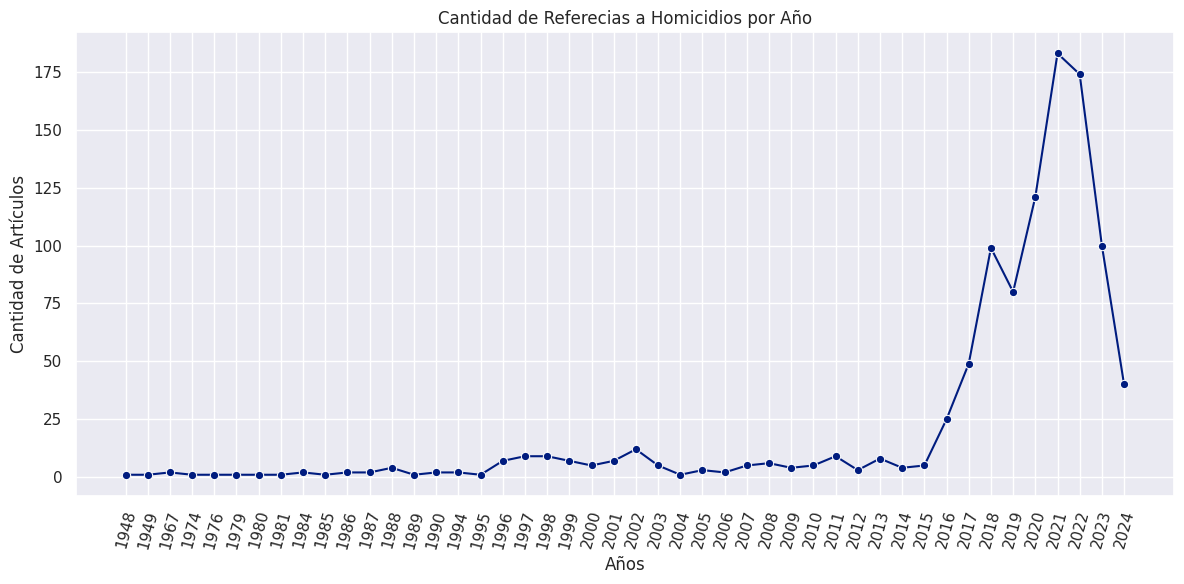

In [ ]:
# Contar los registros por periodo
conteo_por_anio = df_noticias.groupby(['anio_est']).size().reset_index(name='Cantidad')
conteo_por_anio
# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.lineplot(data=conteo_por_anio, x='anio_est', y='Cantidad', marker='o')
plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Cantidad de Referecias a Homicidios por Año')
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.show()

###Antes de 2017

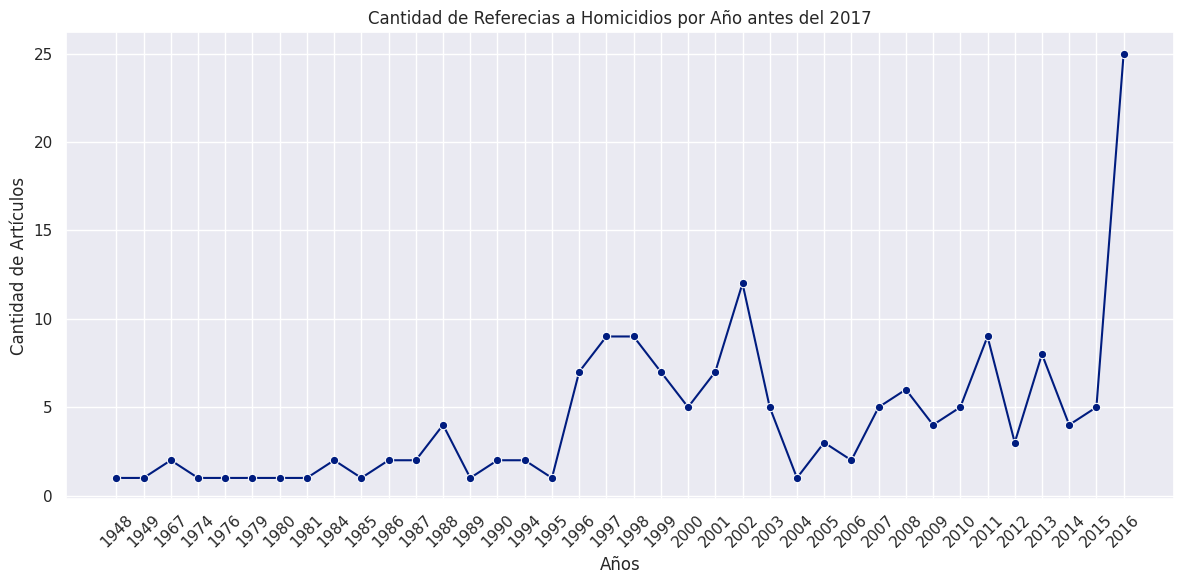

In [ ]:
#filtrar los registros antes de 2017
df_before2017_est = df_noticias[df_noticias['fecha_est'].dt.year < 2017]
# Contar los registros por año
conteo_before2017_anio_est = df_before2017_est['anio_est'].value_counts().sort_index()
# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.lineplot(x=conteo_before2017_anio_est.index, y=conteo_before2017_anio_est.values, marker='o')
plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Cantidad de Referecias a Homicidios por Año antes del 2017')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Contar el número de registros
num_registros_bef2017 = len(df_before2017_est)
print(f'Número de registros antes del 2017: {num_registros_bef2017}')

Número de registros antes del 2017: 167


###Desde 2017

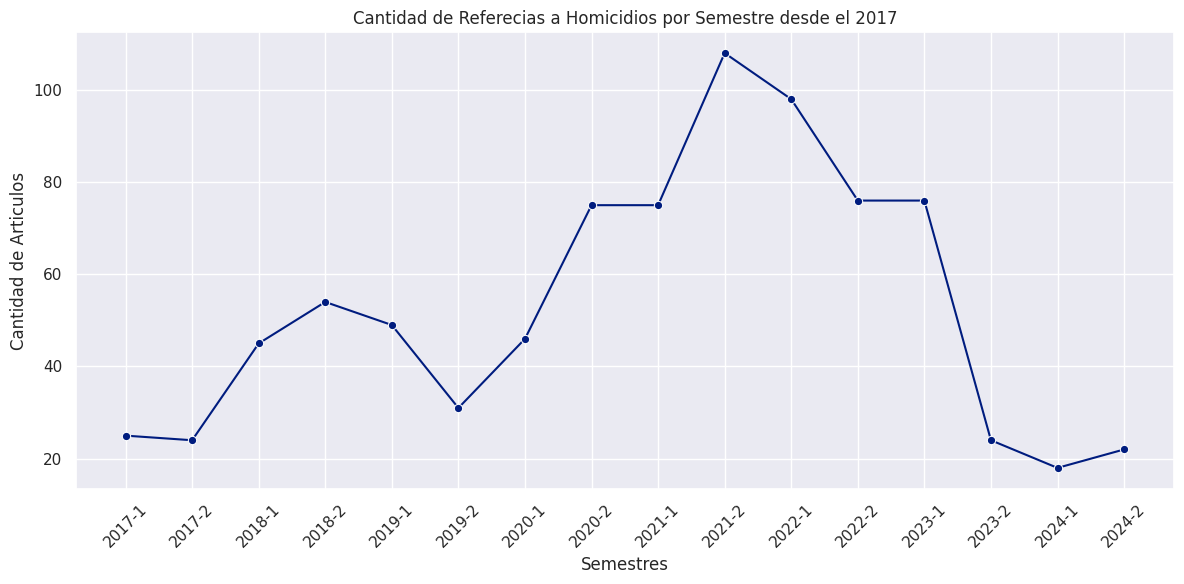

In [ ]:
#filtrar los registros desde 2017
df_from2017_est = df_noticias[df_noticias['fecha_est'].dt.year >= 2017]
# Contar los registros por trimestre a partir del 2017
conteo_por_semestre = df_from2017_est['semestre_est'].value_counts().sort_index()
# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.lineplot(x=conteo_por_semestre.index, y=conteo_por_semestre.values, marker='o')
plt.xlabel('Semestres')
plt.ylabel('Cantidad de Articulos')
plt.title('Cantidad de Referecias a Homicidios por Semestre desde el 2017')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Se realiza una comparación de las fechas conocidas como fecha estimada, fecha del artículo y la fecha del evento.

<ipython-input-13-b1c43ec9b712>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_from2017_eve_sn['fechaevento'] = pd.to_datetime(df_from2017_eve_sn['fechaevento'])
<ipython-input-13-b1c43ec9b712>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_from2017_eve_sn['trimestre_eve'] = df_from2017_eve_sn['fechaevento'].dt.year.astype(str) + '-' + df_from2017_eve_sn['fechaevento'].dt.quarter.astype(str)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-

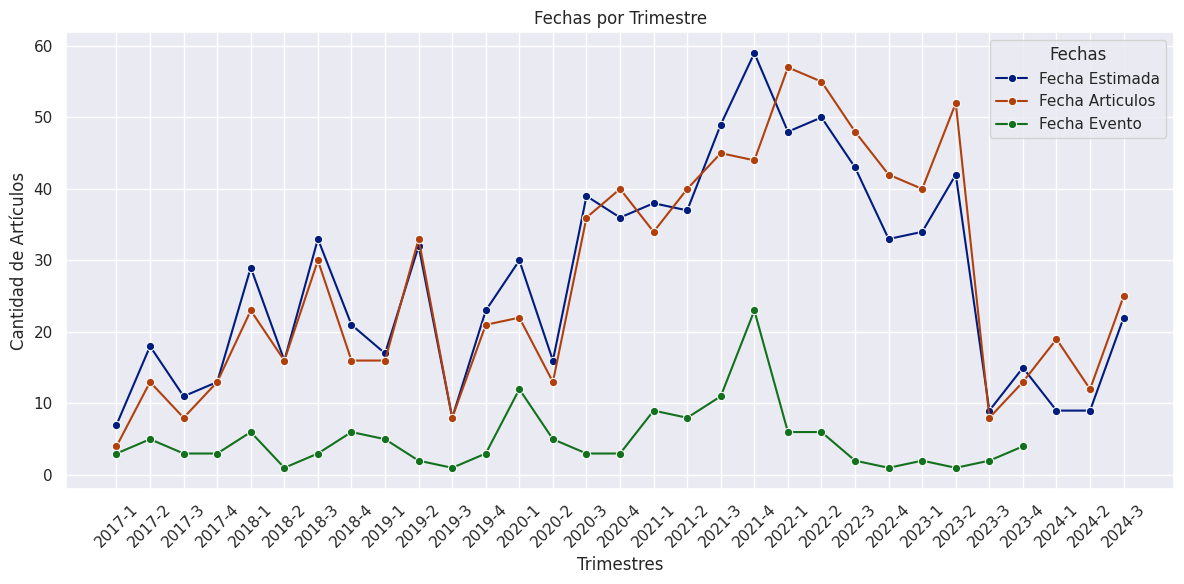

In [ ]:
# Contar los registros por trimestre por la fecha estimada
conteo_por_trimestre_est = df_from2017_est['trimestre_est'].value_counts().reset_index(name='Conteo')
conteo_por_trimestre_est['agrupacion'] = 'Fecha Estimada'
conteo_por_trimestre_est.rename(columns={'trimestre_est': 'trimestre'}, inplace=True)
conteo_por_trimestre_est

# Contar los registros por trimestre por la fecha articulo
conteo_por_trimestre_art = df_from2017_est['trimestre_art'].value_counts().reset_index(name='Conteo')
conteo_por_trimestre_art['agrupacion'] = 'Fecha Articulos'
conteo_por_trimestre_art.rename(columns={'trimestre_art': 'trimestre'}, inplace=True)
conteo_por_trimestre_art

# Contar los registros por trimestre por la fecha de evento - se bede reformatear los tipos de datos al generar el nuevo dataset
df_from2017_eve = df_from2017_est[['fechaevento','trimestre_eve']]
df_from2017_eve_sn = df_from2017_eve.dropna(how='any')
df_from2017_eve_sn['fechaevento'] = pd.to_datetime(df_from2017_eve_sn['fechaevento'])
df_from2017_eve_sn['trimestre_eve'] = df_from2017_eve_sn['fechaevento'].dt.year.astype(str) + '-' + df_from2017_eve_sn['fechaevento'].dt.quarter.astype(str)
conteo_por_trimestre_eve = df_from2017_eve_sn['trimestre_eve'].value_counts().reset_index(name='Conteo')
conteo_por_trimestre_eve['agrupacion'] = 'Fecha Evento'
conteo_por_trimestre_eve.rename(columns={'trimestre_eve': 'trimestre'}, inplace=True)
conteo_por_trimestre_eve

df_combinado = pd.concat([conteo_por_trimestre_est, conteo_por_trimestre_art, conteo_por_trimestre_eve])
df_sort = df_combinado.sort_values(by='trimestre')
df_sort
# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sort, x='trimestre', y='Conteo', hue='agrupacion', marker='o')
plt.xlabel('Trimestres')
plt.ylabel('Cantidad de Artículos')
plt.title('Fechas por Trimestre')
plt.legend(title='Fechas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

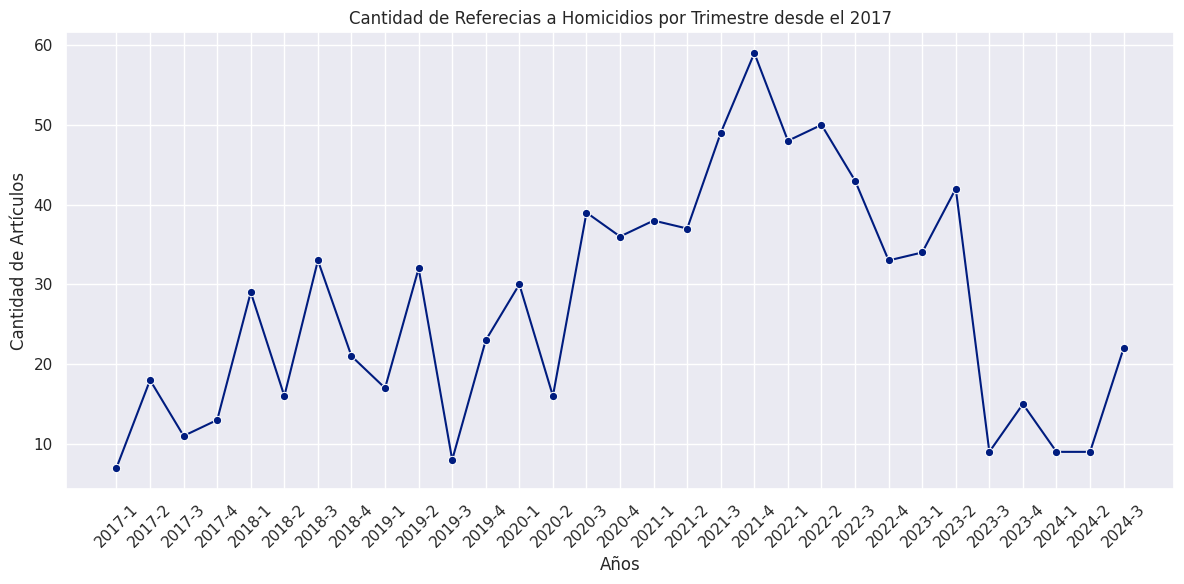

In [ ]:
# Contar los registros por trimestre
conteo_por_trimestre = df_from2017_est['trimestre_est'].value_counts().sort_index()
# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.lineplot(x=conteo_por_trimestre.index, y=conteo_por_trimestre.values, marker='o')
plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Cantidad de Referecias a Homicidios por Trimestre desde el 2017')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

###Delitos relacionados a los homicidios

In [35]:
#Ajustes de estilo
sns.set_theme(style="white", palette="deep", context="notebook")
# Definir los colores específicos para cada valor de departamento
colores_delitosrelacionados = {
    'Sin identificar': '#4C72B0', #Azul
    'Solo homicidio': '#4C72B0', #Azul
    'Feminicidio': '#DA8BC3',  #Rosa
    'Violación': '#CCB974', #Gris
    'Secuestro': '#55A868', #Verde
    'Masacre': '#C44E52', #Rojo
    'Narcotráfico': '#DD8452', #Naranja
    'Robo': '#937860', #Naranja
    'Terrorismo': '#64B5CD' #Naranja
}
sns.despine()
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

<Figure size 640x480 with 0 Axes>

####Antes de 2017

Delitos Relacionados
Sin identificar    63
Masacre            44
Secuestro          33
Violación          29
Robo               25
Narcotráfico       22
Feminicidio         8
Terrorismo          6
Name: count, dtype: int64


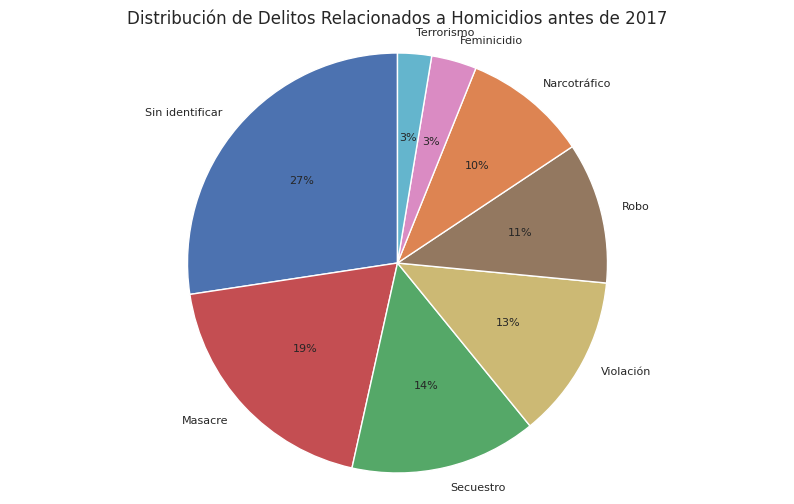

In [ ]:
# Conteo de delitos
delitos_list_before2017 = df_before2017_est['delitos_relacionados'].explode('delitos_relacionados')  # Descomponer la lista en filas
#Renombrar la serie
delitos_list_before2017_rn = delitos_list_before2017.rename('Delitos Relacionados')
delitos_list_before2017_rn

#Remplazar NaN por "Sin identificar" y dejar la primera letra en Mayuscula
delitos_list_before2017_rn = delitos_list_before2017_rn.fillna('Sin identificar').str.capitalize()
#conteo de delitos
delitos_counter_before2017 = delitos_list_before2017_rn.value_counts()

print(delitos_counter_before2017)

# Obtener los colores correspondientes a cada etiqueta
colors = [colores_delitosrelacionados[delito] for delito in delitos_counter_before2017.index]
# Generar la gráfica tipo torta
plt.figure(figsize=(10, 6))
plt.pie(delitos_counter_before2017, labels=delitos_counter_before2017.index, autopct='%1.0f%%', textprops={'fontsize': 8}, startangle=90, colors=colors)
plt.title('Distribución de Delitos Relacionados a Homicidios antes de 2017')
plt.axis('equal')  # Para asegurar que la gráfica sea un círculo
plt.show()

####Desde 2017

Delitos Relacionados
Sin identificar    397
Narcotráfico       145
Robo               123
Masacre            108
Secuestro           81
Feminicidio         58
Violación           57
Terrorismo          48
Name: count, dtype: int64


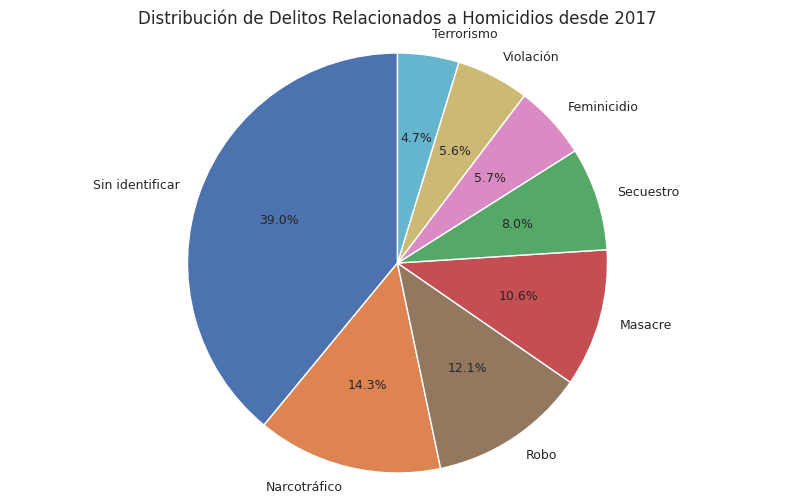

In [ ]:
# Descomponer la lista en filas
delitos_list = df_from2017_est['delitos_relacionados'].explode('delitos_relacionados')
delitos_list_rn = delitos_list.rename('Delitos Relacionados')
#Remplazar NaN por "Sin identificar" y convertir el primer caracter en mayuscula
delitos_list_rn = delitos_list_rn.fillna('Sin identificar').str.capitalize()
delitos_list_rn
#conteo de delitos
delitos_counter = delitos_list_rn.value_counts()

print(delitos_counter)

# Obtener los colores correspondientes a cada etiqueta
colors = [colores_delitosrelacionados[delito] for delito in delitos_counter.index]
# Generar la gráfica tipo torta
plt.figure(figsize=(10, 6))
plt.pie(delitos_counter, labels=delitos_counter.index, autopct='%1.1f%%', textprops={'fontsize': 9}, startangle=90, colors=colors)
plt.title('Distribución de Delitos Relacionados a Homicidios desde 2017')
plt.axis('equal')  # Para asegurar que la gráfica sea un círculo
plt.show()

Como parte de los picos mas altos fue en el 2021 y el 2022 se analiza estos años por los delitos relacionados, para también poder comparar esos meses contra el historico desde 2017.

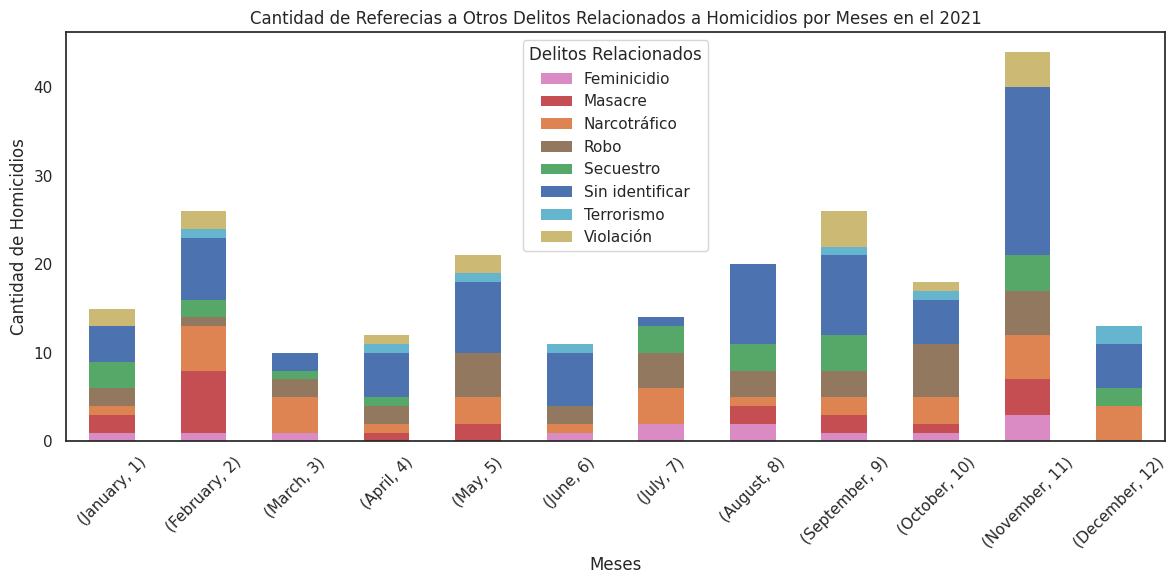

In [ ]:
#filtrar del año
df_2021 = df_noticias[df_noticias['fecha_est'].dt.year == 2021]
# Explode para descomponer los delitos en filas
df_explorar_otros_delitos_2021 = df_2021.explode('delitos_relacionados')
df_otros_delitos_2021_sinlistas = df_explorar_otros_delitos_2021.drop(columns=["personas_involucradas","tokenizaciontitulo"])
df_otros_delitos_2021 = df_otros_delitos_2021_sinlistas.drop_duplicates()
df_otros_delitos_2021
#Remplazar NaN por "Sin identificar"
df_otros_delitos_2021 = df_otros_delitos_2021.fillna('Sin identificar')
# Convertir el primer carácter de cada valor en la columna 'nombre' a mayúsculas
df_otros_delitos_2021['delitos_relacionados'] = df_otros_delitos_2021['delitos_relacionados'].str.capitalize()
# Agrupar por mes y delitos relacionados
df_otros_delitos_2021_xmes = df_otros_delitos_2021.groupby(['mes_est','mes_est_numero','delitos_relacionados']).size().unstack(fill_value=0)
df_otros_delitos_2021_xmes = df_otros_delitos_2021_xmes.sort_values(by="mes_est_numero")

# Obtener los colores correspondientes a cada delito usando el diccionario
colors = [colores_delitosrelacionados[delito] for delito in df_otros_delitos_2021_xmes.columns]

# Graficar el resultado como un gráfico de barras apiladas
df_otros_delitos_2021_xmes.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='none', color=colors)
# Configuración del gráfico
plt.xlabel('Meses')
plt.ylabel('Cantidad de Homicidios')
plt.title('Cantidad de Referecias a Otros Delitos Relacionados a Homicidios por Meses en el 2021')
plt.xticks(rotation=45)
plt.legend(title='Delitos Relacionados')
plt.tight_layout()
plt.show()

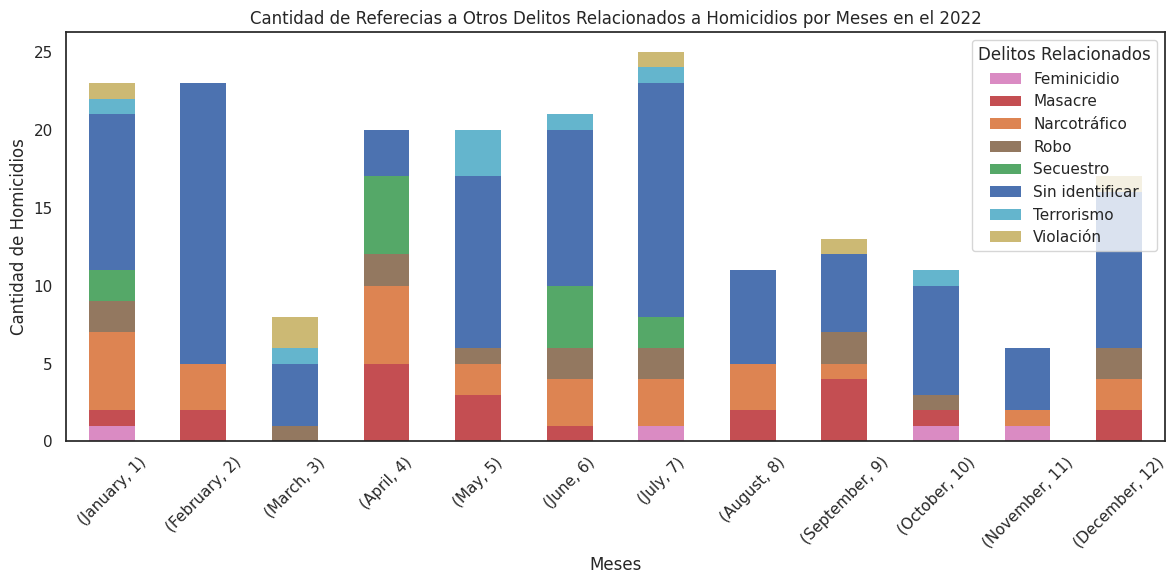

In [ ]:
#filtrar del año
df_2022 = df_noticias[df_noticias['fecha_est'].dt.year == 2022]
# Explode para descomponer los delitos en filas
df_explorar_otros_delitos_2022 = df_2022.explode('delitos_relacionados')
df_otros_delitos_2022_sinlistas = df_explorar_otros_delitos_2022.drop(columns=["personas_involucradas","tokenizaciontitulo"])
df_otros_delitos_2022 = df_otros_delitos_2022_sinlistas.drop_duplicates()
df_otros_delitos_2022
#Remplazar NaN por "Sin identificar"
df_otros_delitos_2022 = df_otros_delitos_2022.fillna('Sin identificar')
# Convertir el primer carácter de cada valor en la columna 'nombre' a mayúsculas
df_otros_delitos_2022['delitos_relacionados'] = df_otros_delitos_2022['delitos_relacionados'].str.capitalize()
# Agrupar por mes y delitos relacionados
df_otros_delitos_2022_xmes = df_otros_delitos_2022.groupby(['mes_est','mes_est_numero','delitos_relacionados']).size().unstack(fill_value=0)
df_otros_delitos_2022_xmes = df_otros_delitos_2022_xmes.sort_values(by="mes_est_numero")

# Obtener los colores correspondientes a cada delito usando el diccionario
colors = [colores_delitosrelacionados[delito] for delito in df_otros_delitos_2022_xmes.columns]

# Graficar el resultado como un gráfico de barras apiladas
df_otros_delitos_2022_xmes.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='none', color=colors)
# Configuración del gráfico
plt.xlabel('Meses')
plt.ylabel('Cantidad de Homicidios')
plt.title('Cantidad de Referecias a Otros Delitos Relacionados a Homicidios por Meses en el 2022')
plt.xticks(rotation=45)
plt.legend(title='Delitos Relacionados')
plt.tight_layout()
plt.show()

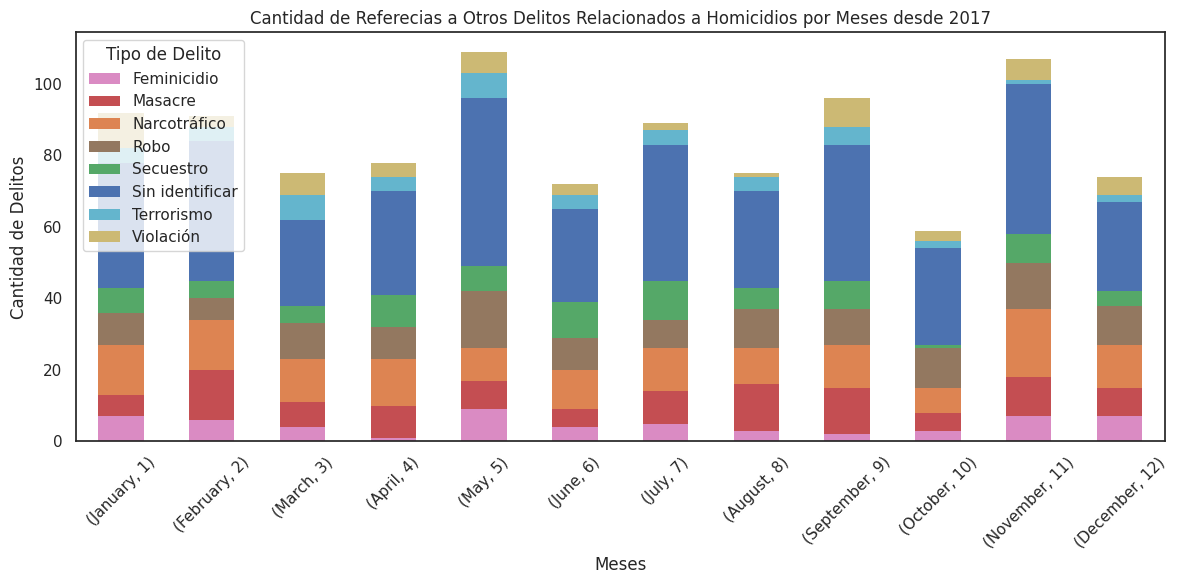

In [ ]:
#Se expanden los datos de delitos relacionalos y se elimina las listas de personas involucradas
df_explorar_otros_delitos_from2017 = df_from2017_est.explode('delitos_relacionados')
df_otros_delitos_from2017_sinlistas = df_explorar_otros_delitos_from2017.drop(columns=["personas_involucradas","tokenizaciontitulo"])
df_otros_delitos_from2017 = df_otros_delitos_from2017_sinlistas.drop_duplicates()
#Remplazar NaN por "Sin identificar"
df_otros_delitos_from2017 = df_otros_delitos_from2017.fillna('Sin identificar')
# Convertir el primer carácter de cada valor en la columna 'nombre' a mayúsculas
df_otros_delitos_from2017['delitos_relacionados'] = df_otros_delitos_from2017['delitos_relacionados'].str.capitalize()
# Agrupar por mes y delitos relacionados
df_otros_delitos_from2017_xmes = df_otros_delitos_from2017.groupby(['mes_est','mes_est_numero','delitos_relacionados']).size().unstack(fill_value=0)
df_otros_delitos_from2017_xmes = df_otros_delitos_from2017_xmes.sort_values(by="mes_est_numero")
df_otros_delitos_from2017_xmes

# Obtener los colores correspondientes a cada delito usando el diccionario
colors = [colores_delitosrelacionados[delito] for delito in df_otros_delitos_from2017_xmes.columns]

# Graficar el resultado como un gráfico de barras apiladas
df_otros_delitos_from2017_xmes.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='none', color=colors)
# Configuración del gráfico
plt.xlabel('Meses')
plt.ylabel('Cantidad de Delitos')
plt.title('Cantidad de Referecias a Otros Delitos Relacionados a Homicidios por Meses desde 2017')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Delito')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


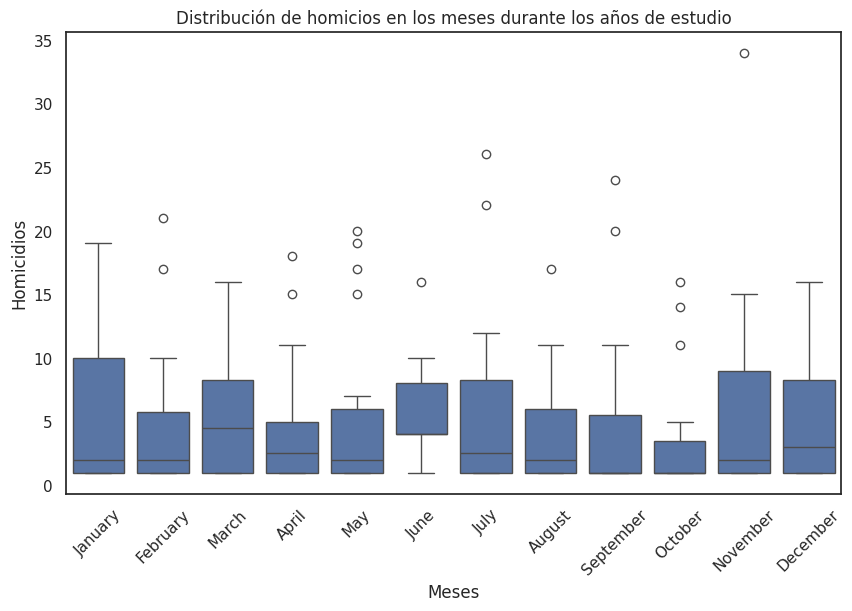

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_conteo_por_meses = df_noticias.groupby(['mes_est','mes_est_numero','anio_est']).size().reset_index(name='Cantidad')
df_conteo_por_meses['Cantidad'] = df_conteo_por_meses['Cantidad'].astype(int)
df_conteo_por_meses

# Graficar boxplot para mostrar los cuartiles por cada mes
plt.figure(figsize=(10, 6))

sns.boxplot(x='mes_est', y='Cantidad', data=df_conteo_por_meses.sort_values('mes_est_numero'), order=df_conteo_por_meses.sort_values('mes_est_numero')['mes_est'])  # Ordenar meses
plt.xticks(rotation=45)  # Rotar etiquetas para legibilidad
plt.title('Distribución de homicios en los meses durante los años de estudio')
plt.ylabel('Homicidios')
plt.xlabel('Meses')
plt.show()

####Histórico



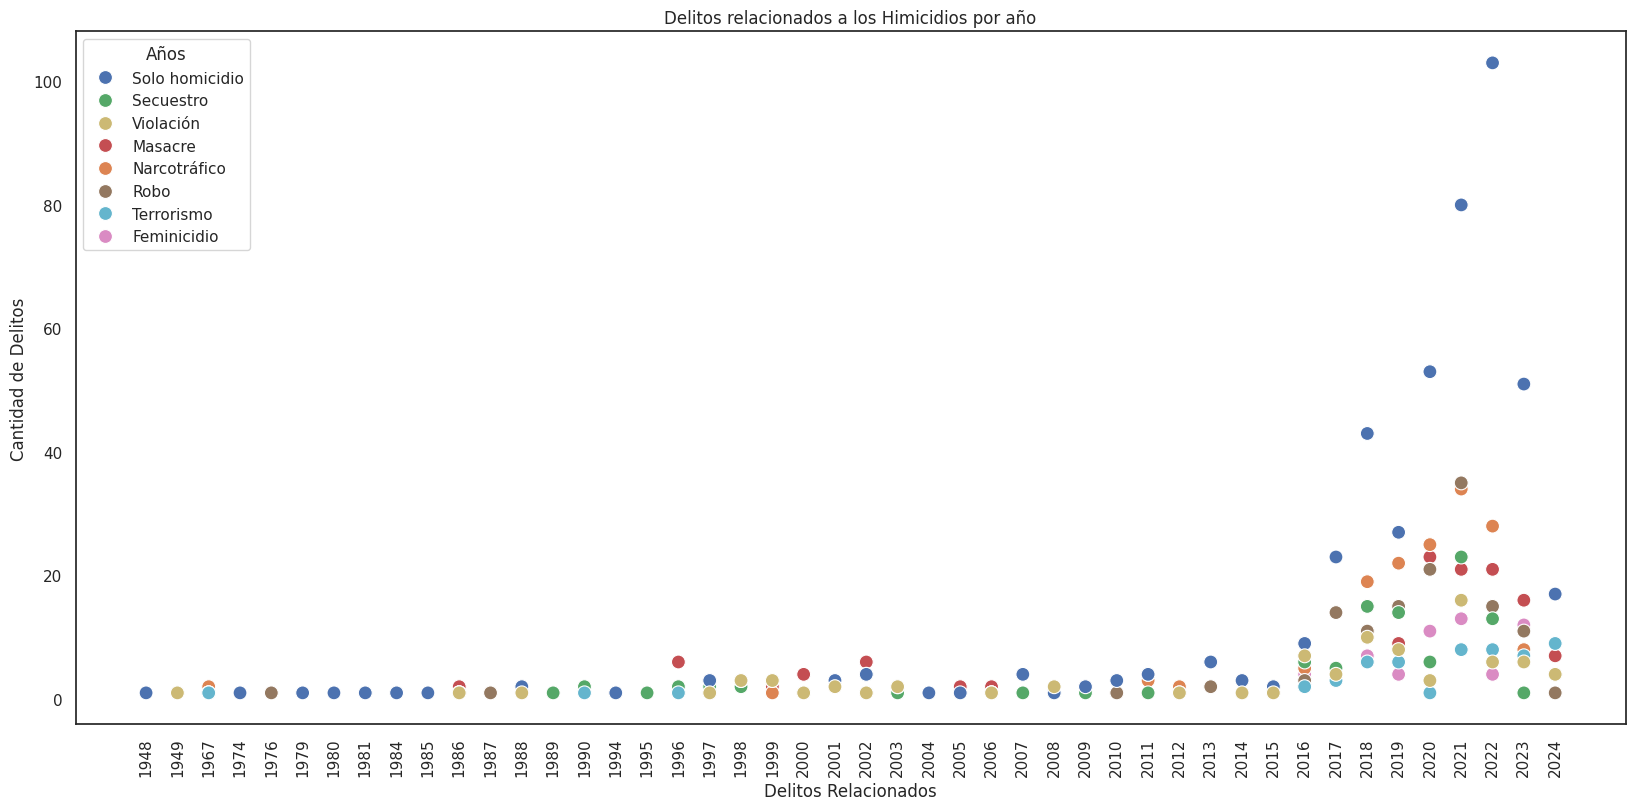

In [41]:
df_explorar_otros_delitos_hist = df_noticias.explode('delitos_relacionados')
df_explorar_otros_delitos_hist_sinlistas = df_explorar_otros_delitos_hist.drop(columns=["personas_involucradas","tokenizaciontitulo"])
df_explorar_otros_delitos_hist_sinlistas['delitos_relacionados'] = df_explorar_otros_delitos_hist_sinlistas['delitos_relacionados'].fillna('Solo homicidio')
df_explorar_otros_delitos_hist_sinlistas['delitos_relacionados'] = df_explorar_otros_delitos_hist_sinlistas['delitos_relacionados'].str.capitalize()
df_delitos_relacionados_hist = df_explorar_otros_delitos_hist_sinlistas.groupby(['anio_est','delitos_relacionados']).size().reset_index(name="casos")
df_delitos_relacionados_hist

# Graficar
plt.figure(figsize=(20, 9))
sns.scatterplot(data=df_delitos_relacionados_hist, x='anio_est', y='casos', hue='delitos_relacionados', palette=colores_delitosrelacionados, s=100)

# Personalizar etiquetas y título
plt.xlabel("Delitos Relacionados")
plt.ylabel("Cantidad de Delitos")
plt.title("Delitos relacionados a los Himicidios por año")
plt.legend(title="Años")
plt.xticks(rotation=90)
plt.show()

##Personas involucradas

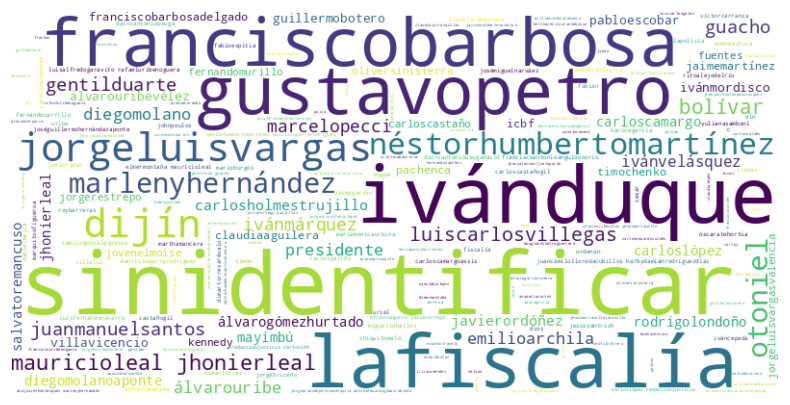

In [ ]:
df_explorar_perdonas_involucradas = df.explode('personas_involucradas')
df_explorar_perdonas_involucradas_sinlistas = df_explorar_perdonas_involucradas.drop(columns=["delitos_relacionados","tokenizaciontitulo"])
df_perdonas_involucradas = df_explorar_perdonas_involucradas_sinlistas.drop_duplicates()
#Remplazar NaN por "Sin identificar"
df_perdonas_involucradas = df_perdonas_involucradas.fillna('Sin identificar')
df_perdonas_involucradas

# Quitar mayúsculas y espacios en la columna 'Registros'
df_perdonas_involucradas['personas_involucradas'] = df_perdonas_involucradas['personas_involucradas'].str.lower()  # Convertir a minúsculas
df_perdonas_involucradas['personas_involucradas'] = df_perdonas_involucradas['personas_involucradas'].str.replace(' ', '', regex=False)  # Quitar espacios
df_perdonas_involucradas['personas_involucradas'] = df_perdonas_involucradas['personas_involucradas'].str.replace('\\n', '', regex=False)  # Quitar espacios
text = ' '.join(df_perdonas_involucradas['personas_involucradas'])
text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.show()

##Títulos de los artículos

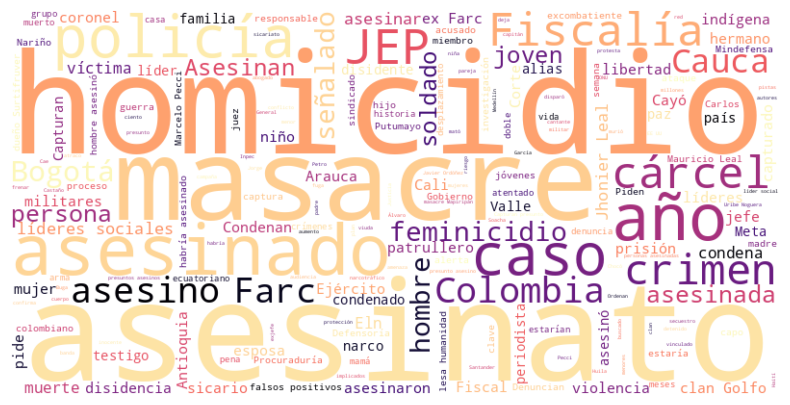

In [ ]:
df_explorar_tokens_titulo = df.explode('tokenizaciontitulo')
df_explorar_tokens_titulo_sinlistas = df_explorar_tokens_titulo.drop(columns=["delitos_relacionados","personas_involucradas"])
#Remplazar NaN por "Sin identificar"
df_explorar_tokens = df_explorar_tokens_titulo_sinlistas.dropna(subset=['tokenizaciontitulo'])
text = ' '.join(df_explorar_tokens['tokenizaciontitulo'])
text
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.show()

---
# Homicidios Georreferenciados
---

En el siguiente mapa de calor se puede apreciar la cantidad de artículos escritos en el periódico El Tiempo sobre casos de homicidios que se son relacionados en alguna ciudad o departamento de Colombia. Se ordena descendentemente por años donde los primeros son los años en los que mas artículos se escribieron.

Text(0.5, 1.0, 'Artículos de homicidios por año')

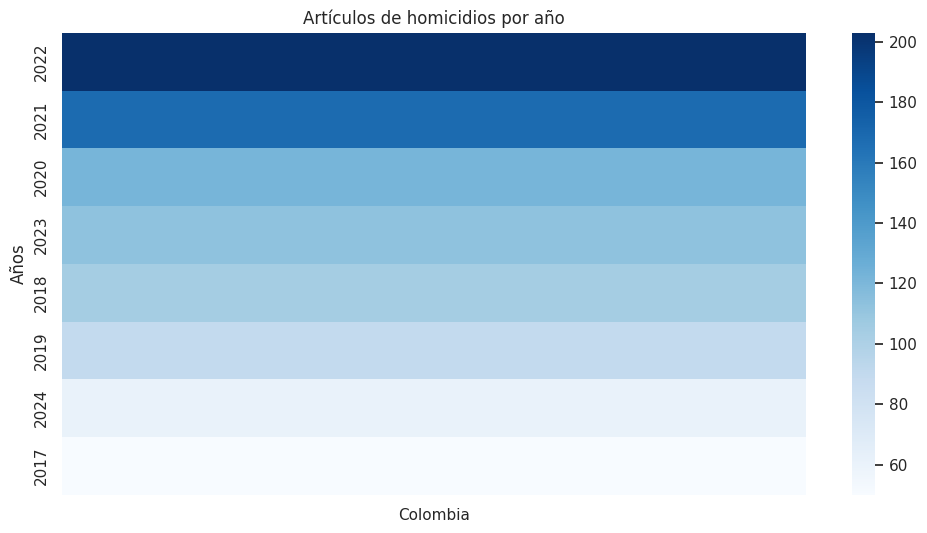

In [ ]:
df_noticias_colombia = df_noticias[df_noticias['pais'] == "Colombia"]
df_noticias_colombia
plt.subplots(figsize=(12, 6))
df_pais = pd.DataFrame({
    x_label: grp['anio_art'].value_counts()
    for x_label, grp in df_noticias_colombia.groupby('pais')
  })
sns.heatmap(df_pais, cmap='Blues')
plt.ylabel('Años')
plt.title('Artículos de homicidios por año')

In [ ]:
# Contar el número de registros
num_registros = len(df_noticias_colombia)
print(f'Número de registros de artículos que se localizaron en Colombia: {num_registros}')

Número de registros de artículos que se localizaron en Colombia: 911


In [ ]:
df_geografia_pais = df_noticias
df_geografia_pais['pais'] = df_geografia_pais['pais'].fillna('Sin identificar')
df_geografia_pais
df_geografia_counter_pais = df_geografia_pais.groupby(['pais']).size()
df_geografia_counter_pais

<ipython-input-50-cf820cf03f9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geografia_pais['pais'] = df_geografia_pais['pais'].fillna('Sin identificar')


pais
Colombia           911
Otros Paises        10
Sin identificar     92
dtype: int64

##Homicidios por Departamentos

In [ ]:
colores_delitosrelacionados

{'Sin identificar': '#4C72B0',
 'Feminicidio': '#DA8BC3',
 'Violación': '#CCB974',
 'Secuestro': '#55A868',
 'Masacre': '#C44E52',
 'Narcotráfico': '#DD8452',
 'Robo': '#937860',
 'Terrorismo': '#64B5CD'}

Distribución geográfica:


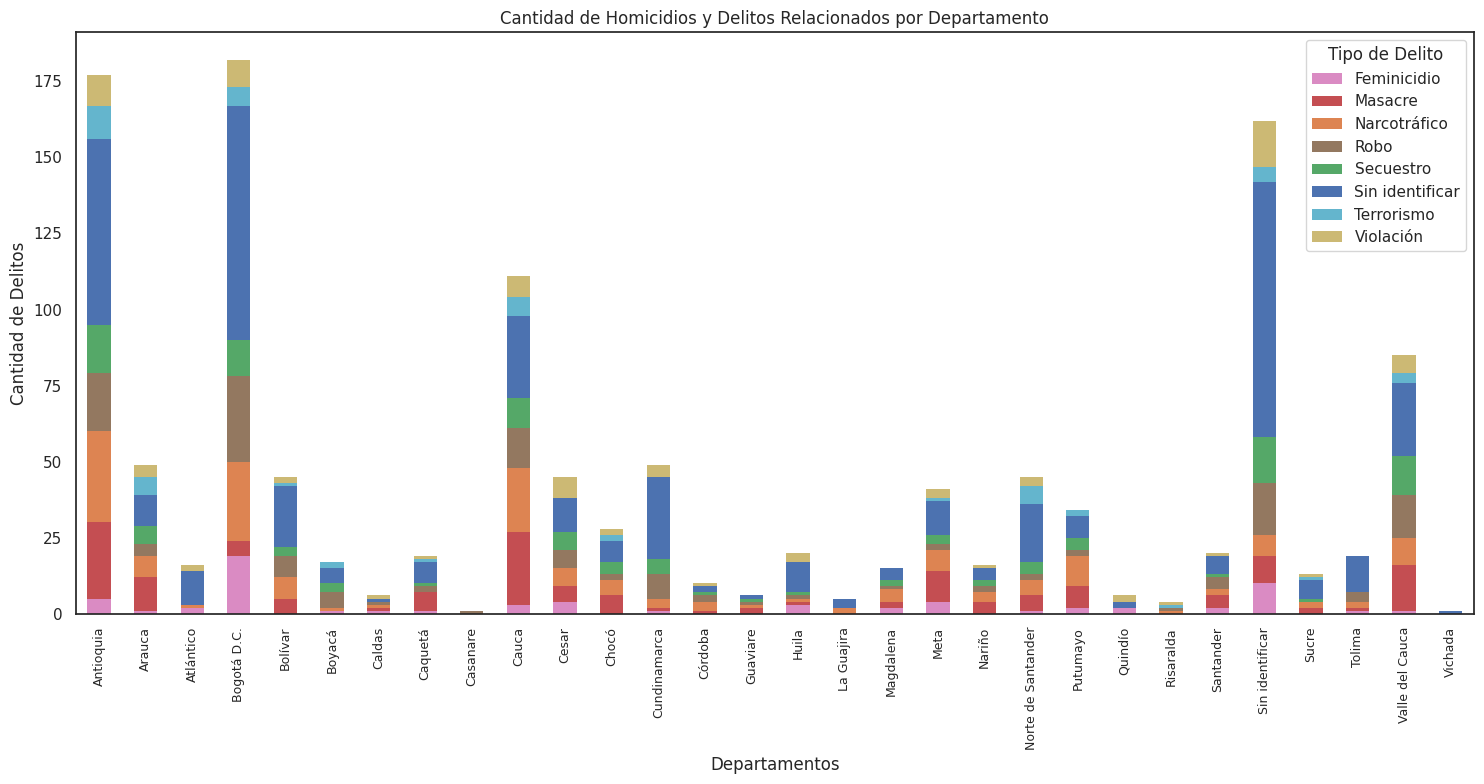

In [ ]:
#Distribución geográfica
geografia_counter = df_noticias.groupby(['pais', 'departamento', 'municipio']).size()

print("Distribución geográfica:")

# Explode para descomponer los delitos en filas
df_exploded = df_noticias.explode('delitos_relacionados')
df_exploded['delitos_relacionados'] = df_exploded['delitos_relacionados'].str.capitalize()
df_exploded = df_exploded.fillna('Sin identificar')

delitos_por_departamento = df_exploded.groupby(['departamento', 'delitos_relacionados']).size().unstack(fill_value=0)

# Obtener los colores correspondientes a cada delito usando el diccionario
colors = [colores_delitosrelacionados[delito] for delito in delitos_por_departamento.columns]

# Graficar el resultado como un gráfico de barras apiladas
delitos_por_departamento.plot(kind='bar', stacked=True, figsize=(15, 8), edgecolor='none', color=colors)

# Configuración del gráfico
plt.xlabel('Departamentos')
plt.ylabel('Cantidad de Delitos')
plt.title('Cantidad de Homicidios y Delitos Relacionados por Departamento')
plt.xticks(rotation=90, fontsize=9)
plt.legend(title='Tipo de Delito')
plt.tight_layout()
plt.show()


In [ ]:
delitos_por_departamento

delitos_relacionados  Feminicidio  Masacre  Narcotráfico  Robo  Secuestro  \
departamento                                                                
Antioquia                       5       25            30    19         16   
Arauca                          1       11             7     4          6   
Atlántico                       2        0             1     0          0   
Bogotá D.C.                    19        5            26    28         12   
Bolívar                         0        5             7     7          3   
Boyacá                          1        0             1     5          3   
Caldas                          1        1             1     1          0   
Caquetá                         1        6             0     2          1   
Casanare                        0        0             0     1          0   
Cauca                           3       24            21    13         10   
Cesar                           4        5             6     6          6   
Chocó                           0        6             5     2          4   
Cundinamarca                    1        1             3     8          5   
Córdoba                         0        1             3     2          1   
Guaviare                        0        2             1     1          1   
Huila                           3        1             1     1          1   
La Guajira                      0        0             2     0          0   
Magdalena                       2        2             4     1          2   
Meta                            4       10             7     2          3   
Nariño                          0        4             3     2          2   
Norte de Santander              1        5             5     2          4   
Putumayo                        2        7            10     2          4   
Quindío                         2        0             0     0          0   
Risaralda                       0        0             1     1          0   
Santander                       2        4             2     4          1   
Sin identificar                10        9             7    17         15   
Sucre                           0        2             2     0          1   
Tolima                          1        1             2     3          0   
Valle del Cauca                 1       15             9    14         13   
Vichada                         0        0             0     0          0   

delitos_relacionados  Sin identificar  Terrorismo  Violación  
departamento                                                  
Antioquia                          61          11         10  
Arauca                             10           6          4  
Atlántico                          11           0          2  
Bogotá D.C.                        77           6          9  
Bolívar                            20           1          2  
Boyacá                              5           2          0  
Caldas                              1           0          1  
Caquetá                             7           1          1  
Casanare                            0           0          0  
Cauca                              27           6          7  
Cesar                              11           0          7  
Chocó                               7           2          2  
Cundinamarca                       27           0          4  
Córdoba                             2           0          1  
Guaviare                            1           0          0  
Huila                              10           0          3  
La Guajira                          3           0          0  
Magdalena                           4           0          0  
Meta                               11           1          3  
Nariño                              4           0          1  
Norte de Santander                 19           6          3  
Putumayo                            7           2          0  
Quindío                

##Trayectoria de homicidios en los 5 departamentos con mas casos
Los casos en Bogotá se sumaran a los casos de Cundinamarca, porque a pesar de ser Bogotá el distrito capital de Colombia sigue siendo la capital de Cundinamarca.

In [ ]:
# Filtrar los 5 departamentos con mas casos
departamentos_a_filtrar = ['Antioquia','Bogotá D.C.', 'Cauca','Valle del Cauca','Arauca','Cundinamarca']
ciudades_a_filtrar = ['Medellín','Bogotá', 'Popayán','Cali','Arauca']

# Definir los colores específicos para cada valor de departamento
colores_departamentos = {'Antioquia': '#581845',  #Violeta oscuro
           'Cundinamarca': '#1f618d',  # Azul
           'Cauca': '#FF5733', # Naranja
           'Valle del Cauca': '#FFC300', #Amarillo
           'Arauca': '#DAF7A6' #Verde
           }

# Definir los colores específicos para cada valor de capital de departamento
colores_ciudades = {'Medellín': '#581845',  #Violeta oscuro
           'Bogotá': '#1f618d',  # Azul
           'Popayán': '#FF5733', # Naranja
           'Cali': '#FFC300', #Amarillo
           'Arauca': '#DAF7A6' #Verde
           }

###Antes de 2017

A continuación, se grafica en lineas los 5 departamentos con más casos:

<ipython-input-59-d7b2693c7eae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dep_mas_casos_before2017['departamento'] = df_dep_mas_casos_before2017['departamento'].replace({'Bogotá D.C.': 'Cundinamarca'})
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to s

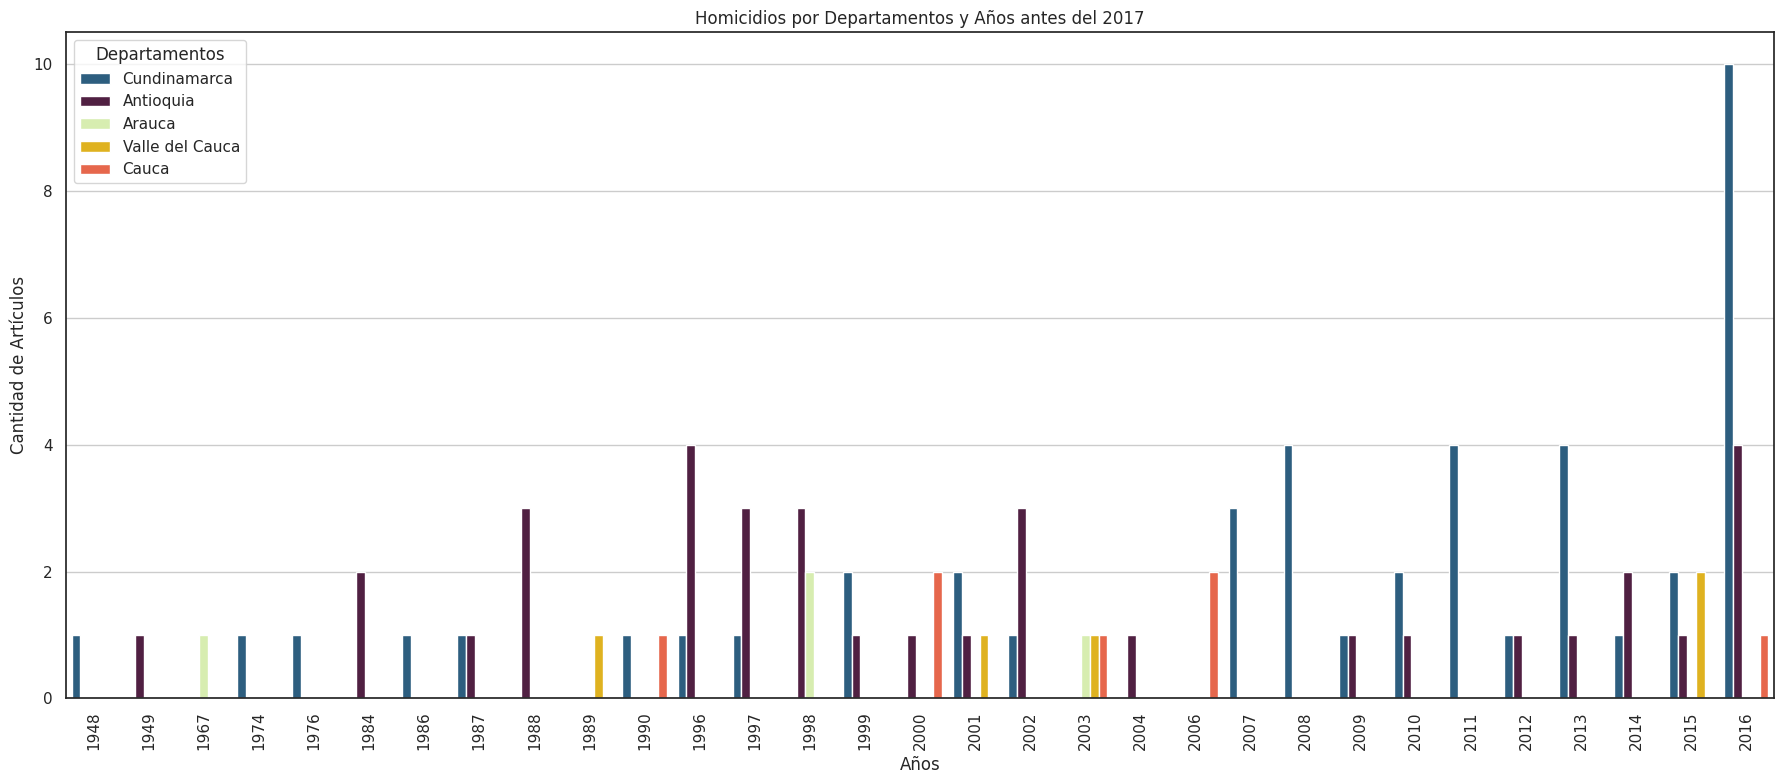

In [ ]:
df_dep_mas_casos_before2017 = df_before2017_est[df_before2017_est['departamento'].isin(departamentos_a_filtrar)]
df_dep_mas_casos_before2017['departamento'] = df_dep_mas_casos_before2017['departamento'].replace({'Bogotá D.C.': 'Cundinamarca'})
df_dep_mas_casos_before2017

df_conteo_por_dep_before2017 = df_dep_mas_casos_before2017.groupby(['anio_est','departamento']).size().reset_index(name='Conteo')
df_conteo_por_dep_before2017.rename(columns={'anio_est': 'Año'}, inplace=True)
df_conteo_por_dep_before2017.rename(columns={'departamento': 'Departamentos'}, inplace=True)
df_conteo_por_dep_before2017['Año'] = df_conteo_por_dep_before2017['Año'].astype(int)
df_conteo_por_dep_before2017.sort_values(by='Año', inplace=True)
df_conteo_por_dep_before2017

# Graficar los resultados
plt.figure(figsize=(18, 8))
sns.barplot(data=df_conteo_por_dep_before2017, x='Año', y='Conteo', hue='Departamentos', palette=colores_departamentos)

plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Homicidios por Departamentos y Años antes del 2017')
plt.legend(title='Departamentos')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

A continuación, se grafica en lineas las 5 capitales de los departamentos con más casos:

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

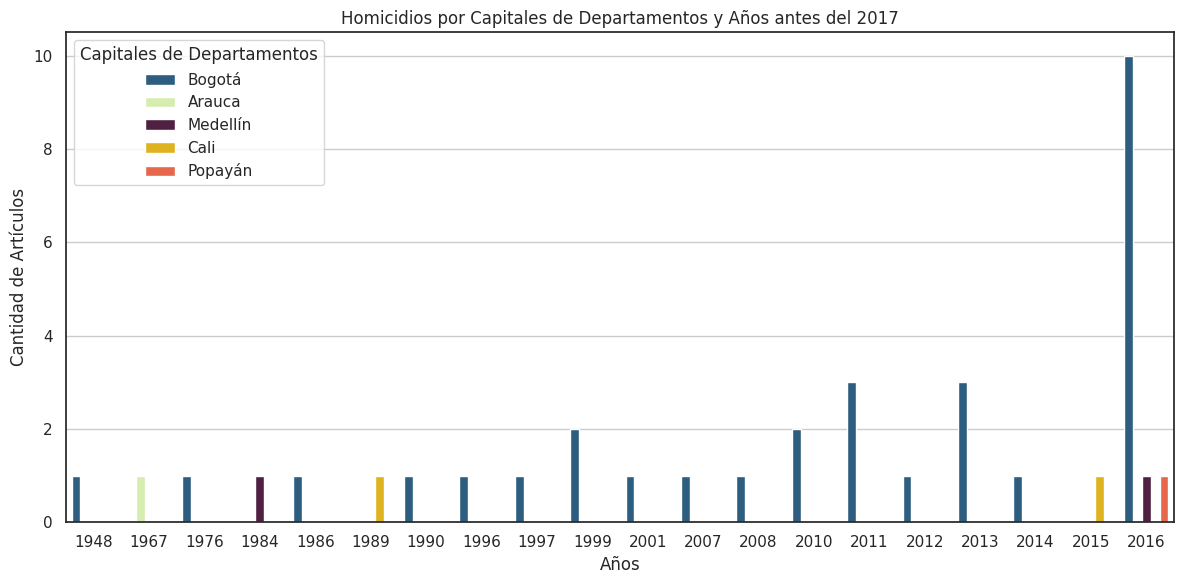

In [ ]:
df_ciu_mas_casos_before2017 = df_before2017_est[df_before2017_est['municipio'].isin(ciudades_a_filtrar)]
df_ciu_mas_casos_before2017

df_conteo_por_ciu_before2017 = df_ciu_mas_casos_before2017.groupby(['anio_est','municipio']).size().reset_index(name='Conteo')
df_conteo_por_ciu_before2017.rename(columns={'anio_est': 'Año'}, inplace=True)
df_conteo_por_ciu_before2017.rename(columns={'municipio': 'Ciudades'}, inplace=True)
df_conteo_por_ciu_before2017['Año'] = df_conteo_por_ciu_before2017['Año'].astype(int)
df_conteo_por_ciu_before2017.sort_values(by='Año', inplace=True)
df_conteo_por_ciu_before2017

# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.barplot(data=df_conteo_por_ciu_before2017, x='Año', y='Conteo', hue='Ciudades', palette=colores_ciudades)

plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Homicidios por Capitales de Departamentos y Años antes del 2017')
plt.legend(title='Capitales de Departamentos')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

###Desde 2017


<ipython-input-382-c56127068791>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dep_mas_casos_from2017['departamento'] = df_dep_mas_casos_from2017['departamento'].replace({'Bogotá D.C.': 'Cundinamarca'})
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to sile

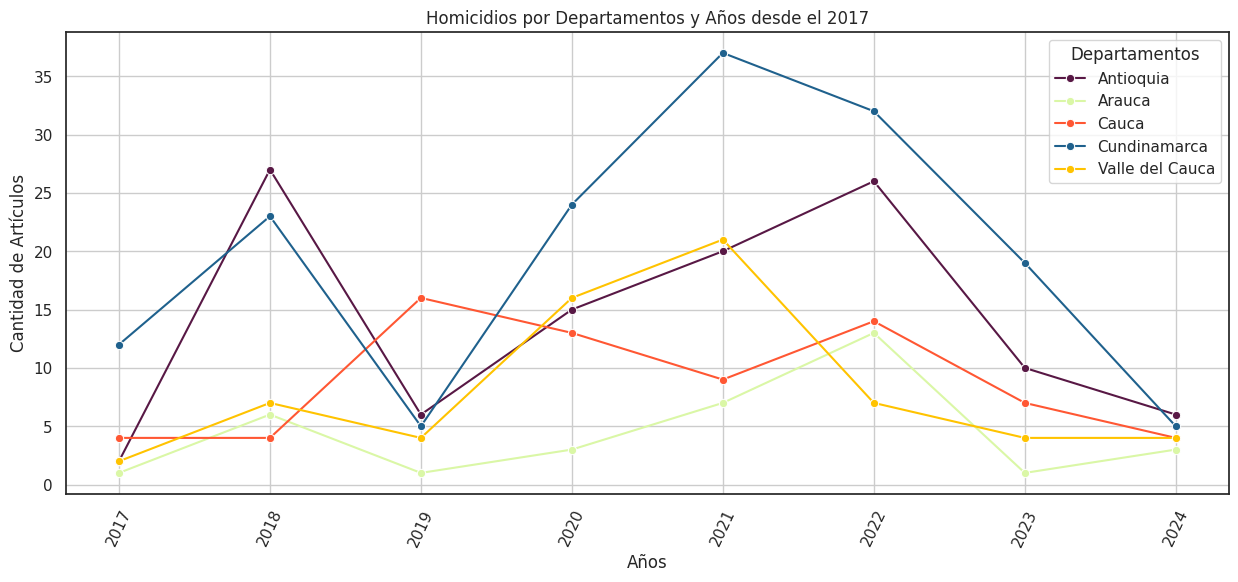

In [ ]:
df_dep_mas_casos_from2017 = df_from2017_est[df_from2017_est['departamento'].isin(departamentos_a_filtrar)]
df_dep_mas_casos_from2017['departamento'] = df_dep_mas_casos_from2017['departamento'].replace({'Bogotá D.C.': 'Cundinamarca'})

df_conteo_por_dep_from2017 = df_dep_mas_casos_from2017.groupby(['anio_est','departamento']).size().reset_index(name='Conteo')
df_conteo_por_dep_from2017.rename(columns={'anio_est': 'Año'}, inplace=True)
df_conteo_por_dep_from2017.rename(columns={'departamento': 'Departamentos'}, inplace=True)
df_conteo_por_dep_from2017['Año'] = df_conteo_por_dep_from2017['Año'].astype(int)
df_conteo_por_dep_from2017.sort_values(by='Año', inplace=True)
df_conteo_por_dep_from2017

# Graficar los resultados
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_conteo_por_dep_from2017, x='Año', y='Conteo', hue='Departamentos', marker='o', palette=colores_departamentos)

plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Homicidios por Departamentos y Años desde el 2017')
plt.legend(title='Departamentos')
plt.xticks(rotation=65)
plt.grid(True)
# plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

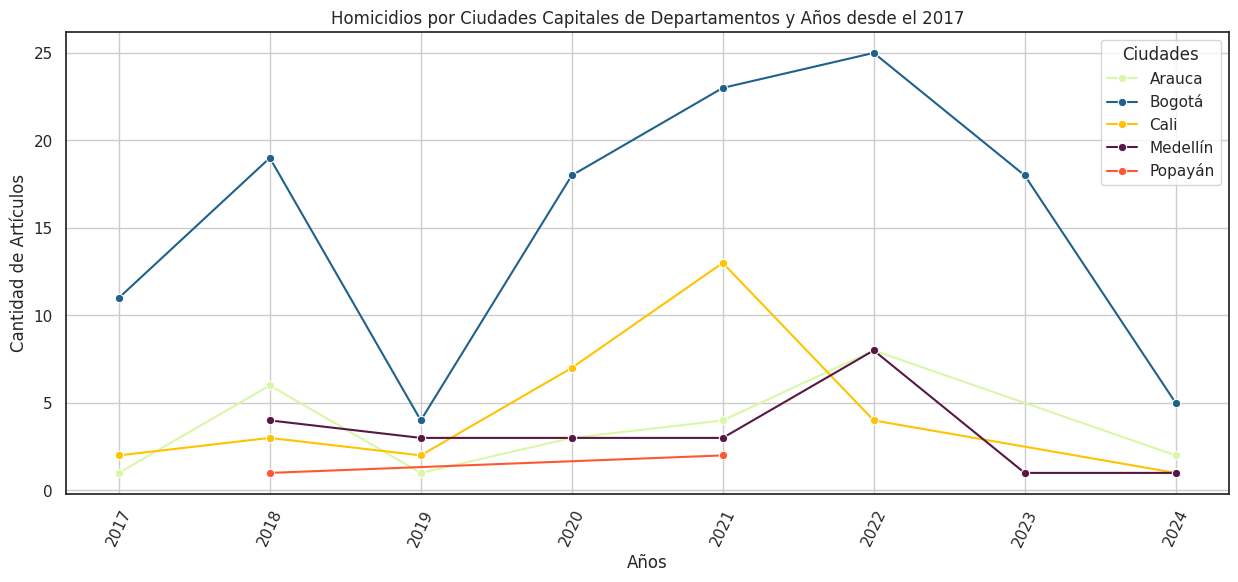

In [ ]:
df_ciu_mas_casos_from2017 = df_from2017_est[df_from2017_est['municipio'].isin(ciudades_a_filtrar)]

df_conteo_por_ciu_from2017 = df_ciu_mas_casos_from2017.groupby(['anio_est','municipio']).size().reset_index(name='Conteo')
df_conteo_por_ciu_from2017.rename(columns={'anio_est': 'Año'}, inplace=True)
df_conteo_por_ciu_from2017.rename(columns={'municipio': 'Ciudades'}, inplace=True)
df_conteo_por_ciu_from2017['Año'] = df_conteo_por_ciu_from2017['Año'].astype(int)
df_conteo_por_ciu_from2017.sort_values(by='Año', inplace=True)
df_conteo_por_ciu_from2017

# Graficar los resultados
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_conteo_por_ciu_from2017, x='Año', y='Conteo', hue='Ciudades', marker='o', palette=colores_ciudades)

plt.xlabel('Años')
plt.ylabel('Cantidad de Artículos')
plt.title('Homicidios por Ciudades Capitales de Departamentos y Años desde el 2017')
plt.legend(title='Ciudades')
plt.xticks(rotation=65)
plt.grid(True)
# plt.tight_layout()
plt.show()

##Clustering

###Departamentos y Años

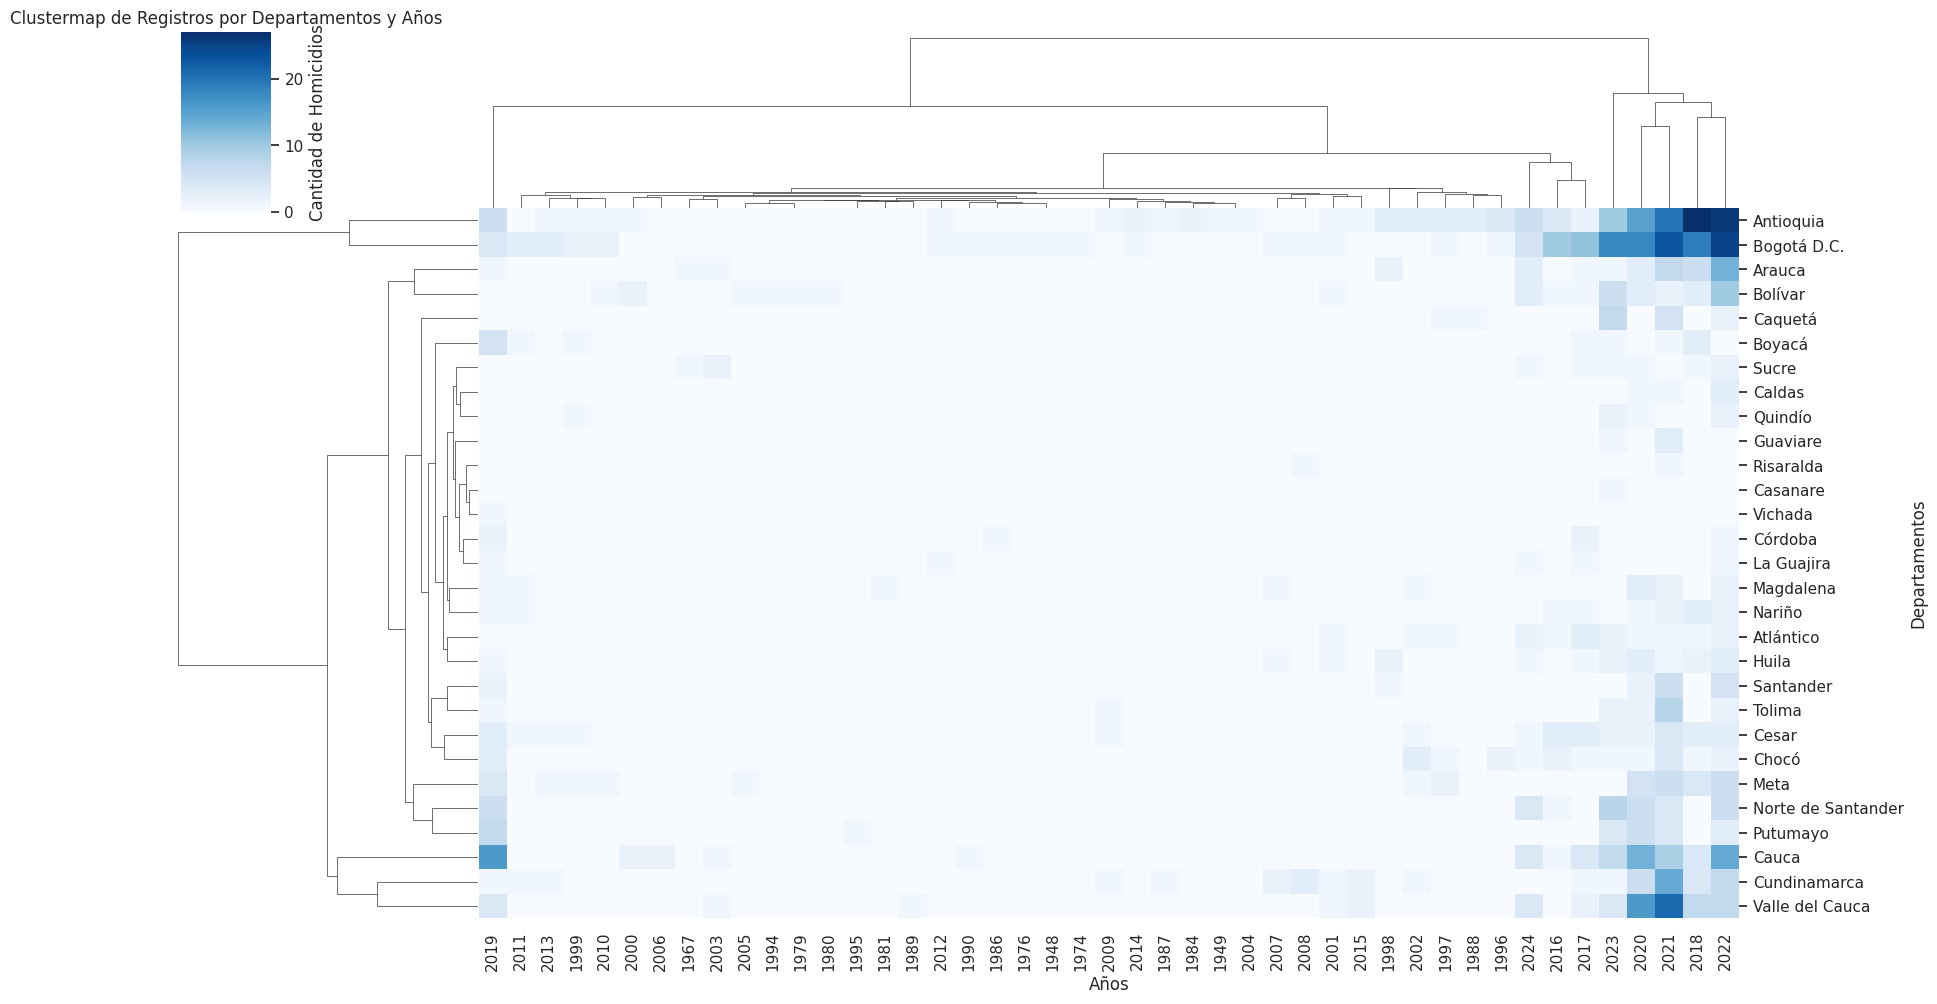

In [ ]:
# Agrupar los datos por Año y Departamento y contar los registros
conteo_por_anio_dep = df_noticias.groupby(['anio_est', 'departamento']).size().reset_index(name='Conteo')
conteo_por_anio_dep.rename(columns={'anio_est': 'Años'}, inplace=True)
conteo_por_anio_dep.rename(columns={'departamento': 'Departamentos'}, inplace=True)
conteo_por_anio_dep

# Crear el DataFrame pivotado para el clustermap
heatmap_data = conteo_por_anio_dep.pivot(index='Departamentos', columns='Años', values='Conteo').fillna(0)

# Crear el clustermap con dendrograma
sns.clustermap(heatmap_data, fmt=".0f", cmap="Blues",
               col_cluster=True, row_cluster=True,
               cbar_kws={'label': 'Cantidad de Homicidios'}, figsize=(18, 10))

# Configuración del gráfico
plt.title('Clustermap de Registros por Departamentos y Años')
plt.show()

###Departamentos y Años a partir del 2017

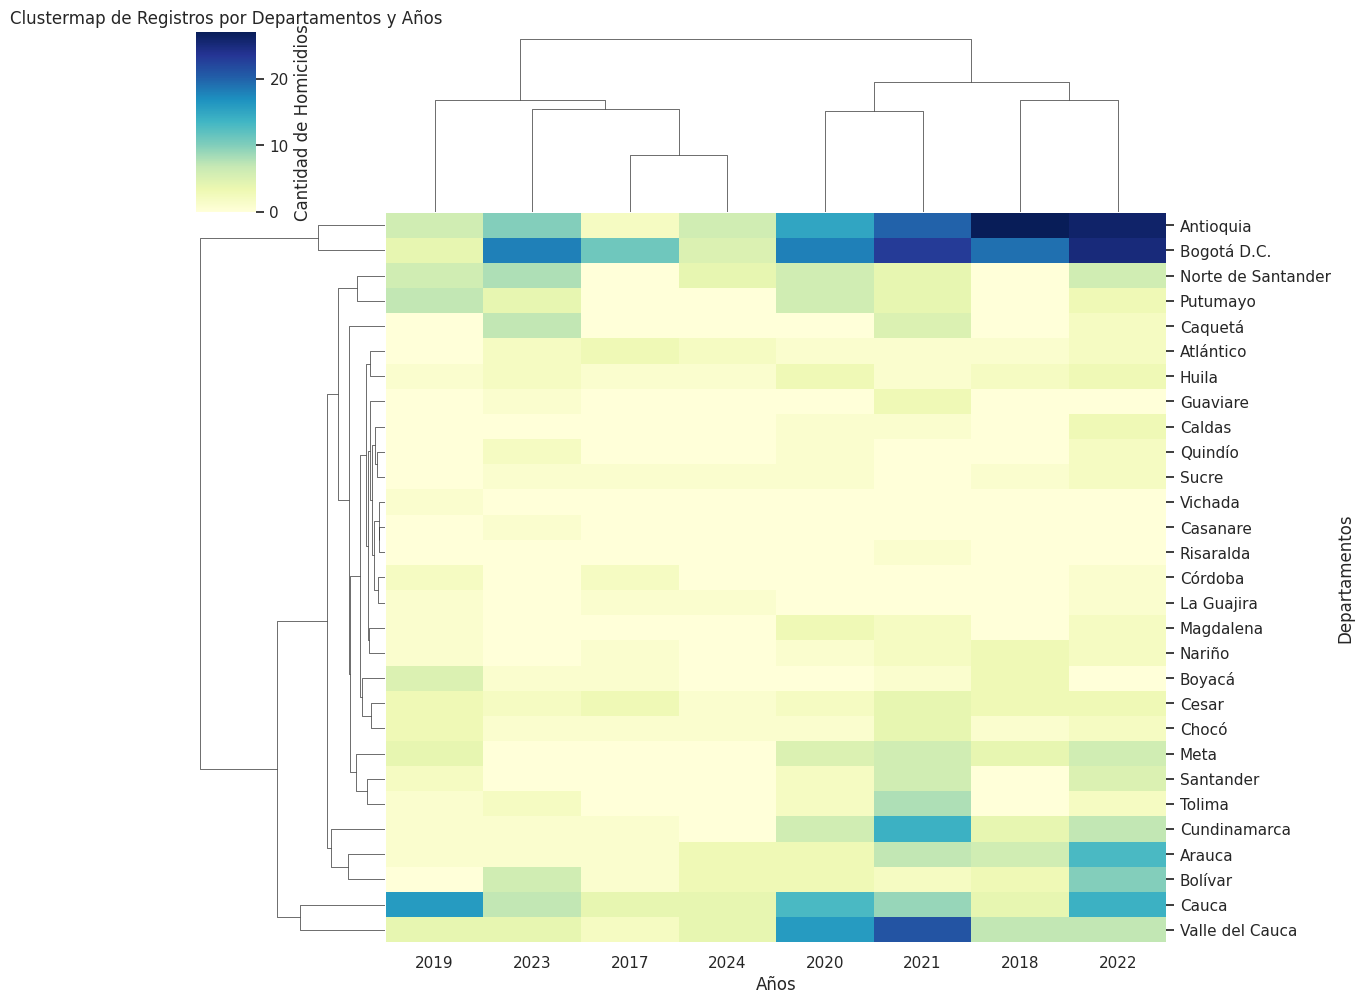

In [ ]:
# Agrupar los datos por Año y Departamento y contar los registros
conteo_por_anio_dep = df_from2017_est.groupby(['anio_est', 'departamento']).size().reset_index(name='Conteo')
conteo_por_anio_dep.rename(columns={'anio_est': 'Años'}, inplace=True)
conteo_por_anio_dep.rename(columns={'departamento': 'Departamentos'}, inplace=True)
conteo_por_anio_dep

# Crear el DataFrame pivotado para el clustermap
heatmap_data = conteo_por_anio_dep.pivot(index='Departamentos', columns='Años', values='Conteo').fillna(0)

# Crear el clustermap con dendrograma
sns.clustermap(heatmap_data, fmt=".0f", cmap="YlGnBu",
               col_cluster=True, row_cluster=True,
               cbar_kws={'label': 'Cantidad de Homicidios'}, figsize=(12, 10))

# Configuración del gráfico
plt.title('Clustermap de Registros por Departamentos y Años')
plt.show()

###Departamentos y Trimestres a partir del 2017

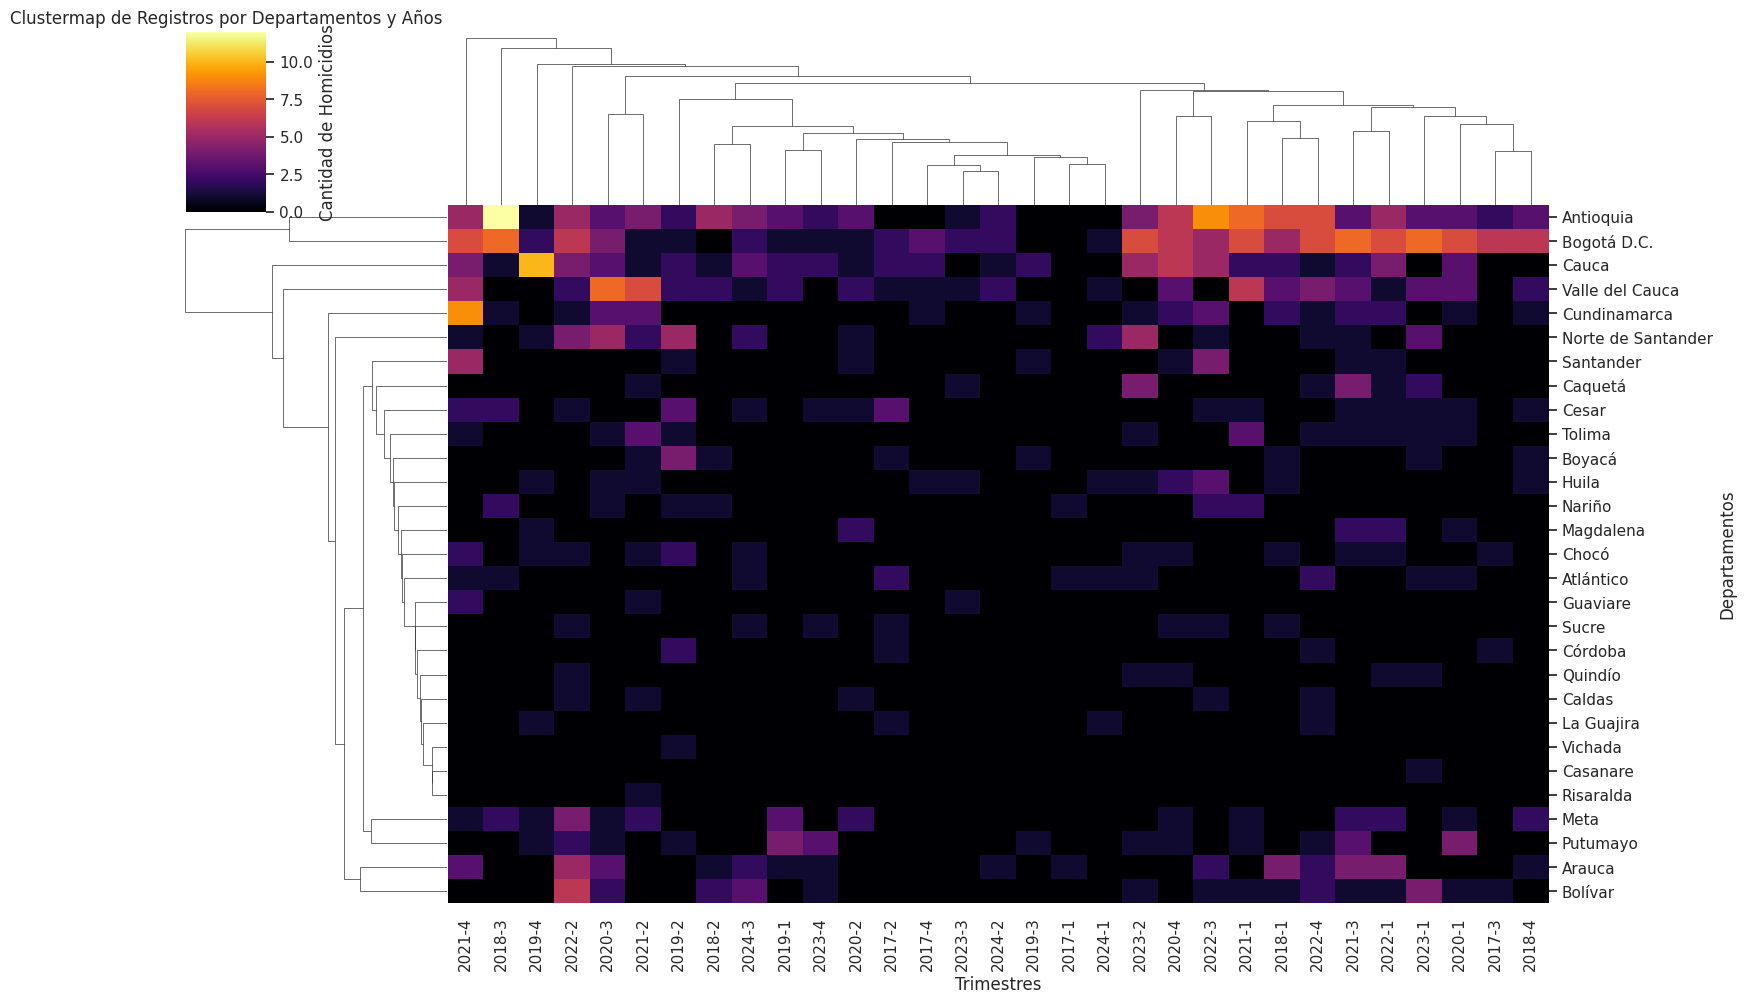

In [ ]:
# Agrupar los datos por Año y Departamento y contar los registros
conteo_por_anio_dep = df_from2017_est.groupby(['trimestre_est', 'departamento']).size().reset_index(name='Conteo')
conteo_por_anio_dep.rename(columns={'trimestre_est': 'Trimestres'}, inplace=True)
conteo_por_anio_dep.rename(columns={'departamento': 'Departamentos'}, inplace=True)
conteo_por_anio_dep

# Crear el DataFrame pivotado para el clustermap
heatmap_data = conteo_por_anio_dep.pivot(index='Departamentos', columns='Trimestres', values='Conteo').fillna(0)

# Crear el clustermap con dendrograma
sns.clustermap(heatmap_data, fmt=".0f", cmap="inferno",
               col_cluster=True, row_cluster=True,
               cbar_kws={'label': 'Cantidad de Homicidios'}, figsize=(16, 10))

# Configuración del gráfico
plt.title('Clustermap de Registros por Departamentos y Años')
plt.show()

###Ciudades y Años

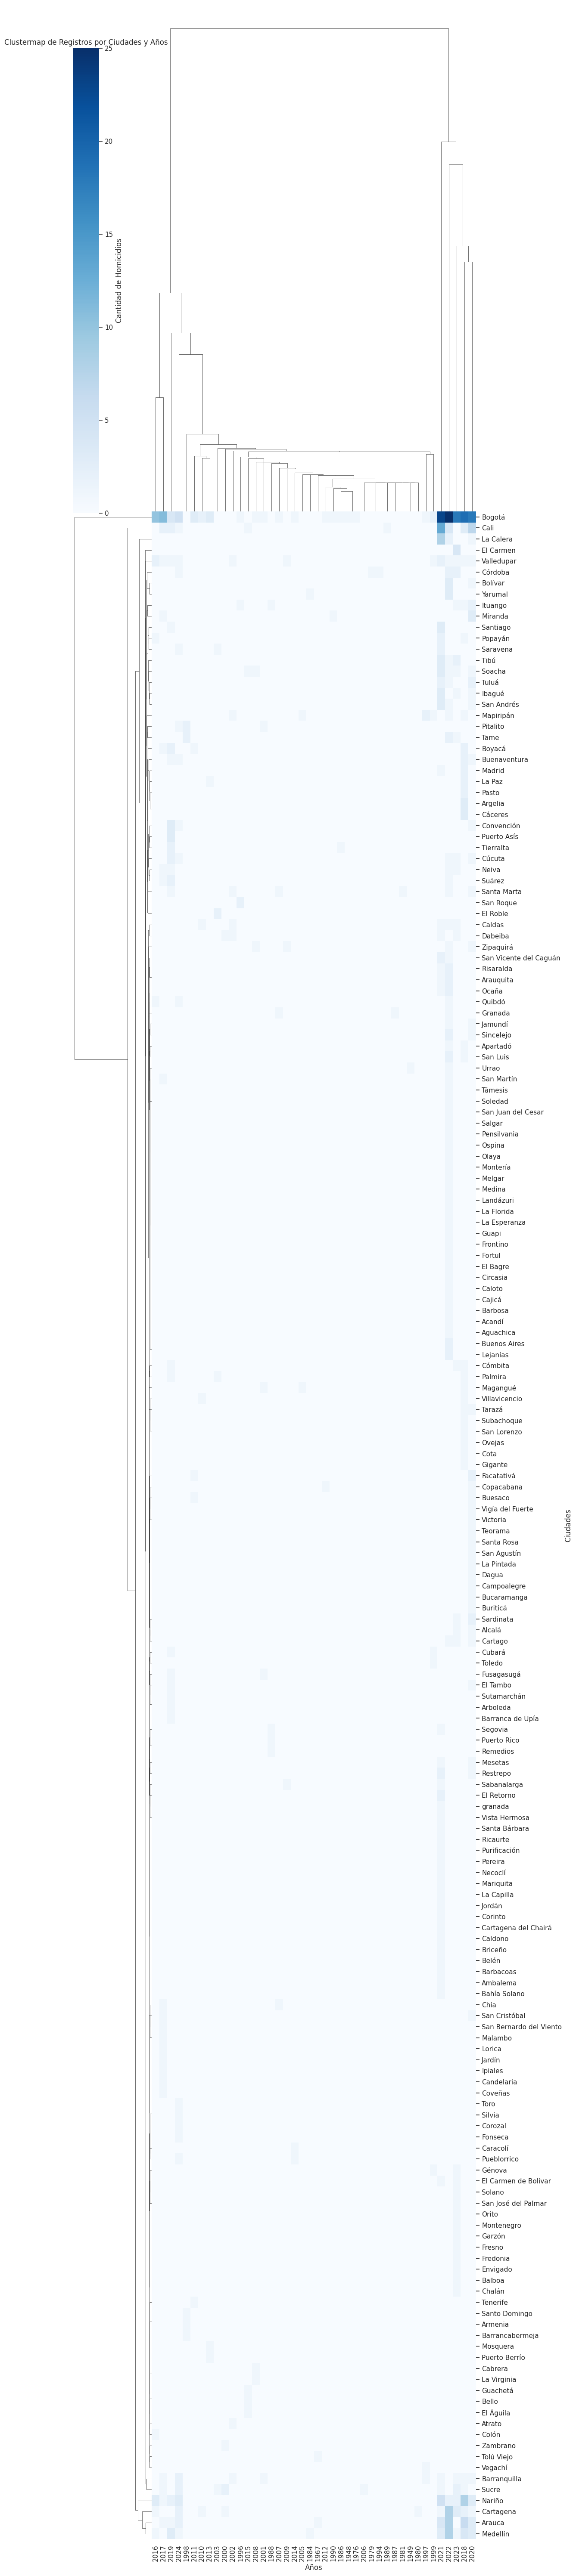

In [ ]:
# Agrupar los datos por Año y Departamento y contar los registros
conteo_por_anio_ciu = df_noticias.groupby(['anio_est', 'municipio']).size().reset_index(name='Conteo')
conteo_por_anio_ciu.rename(columns={'anio_est': 'Años'}, inplace=True)
conteo_por_anio_ciu.rename(columns={'municipio': 'Ciudades'}, inplace=True)
conteo_por_anio_ciu.drop(conteo_por_anio_ciu[conteo_por_anio_ciu['Ciudades'] == 'Sin especificar'].index, inplace=True)
conteo_por_anio_ciu

# Crear el DataFrame pivotado para el clustermap
heatmap_data = conteo_por_anio_ciu.pivot(index='Ciudades', columns='Años', values='Conteo').fillna(0)

# Crear el clustermap con dendrograma
sns.clustermap(heatmap_data, fmt=".0f", cmap="Blues",
               col_cluster=True, row_cluster=True,
               cbar_kws={'label': 'Cantidad de Homicidios'}, figsize=(12, 60))

# Configuración del gráfico
plt.title('Clustermap de Registros por Ciudades y Años')
plt.show()

###Ciudades y Años a partir del 2017

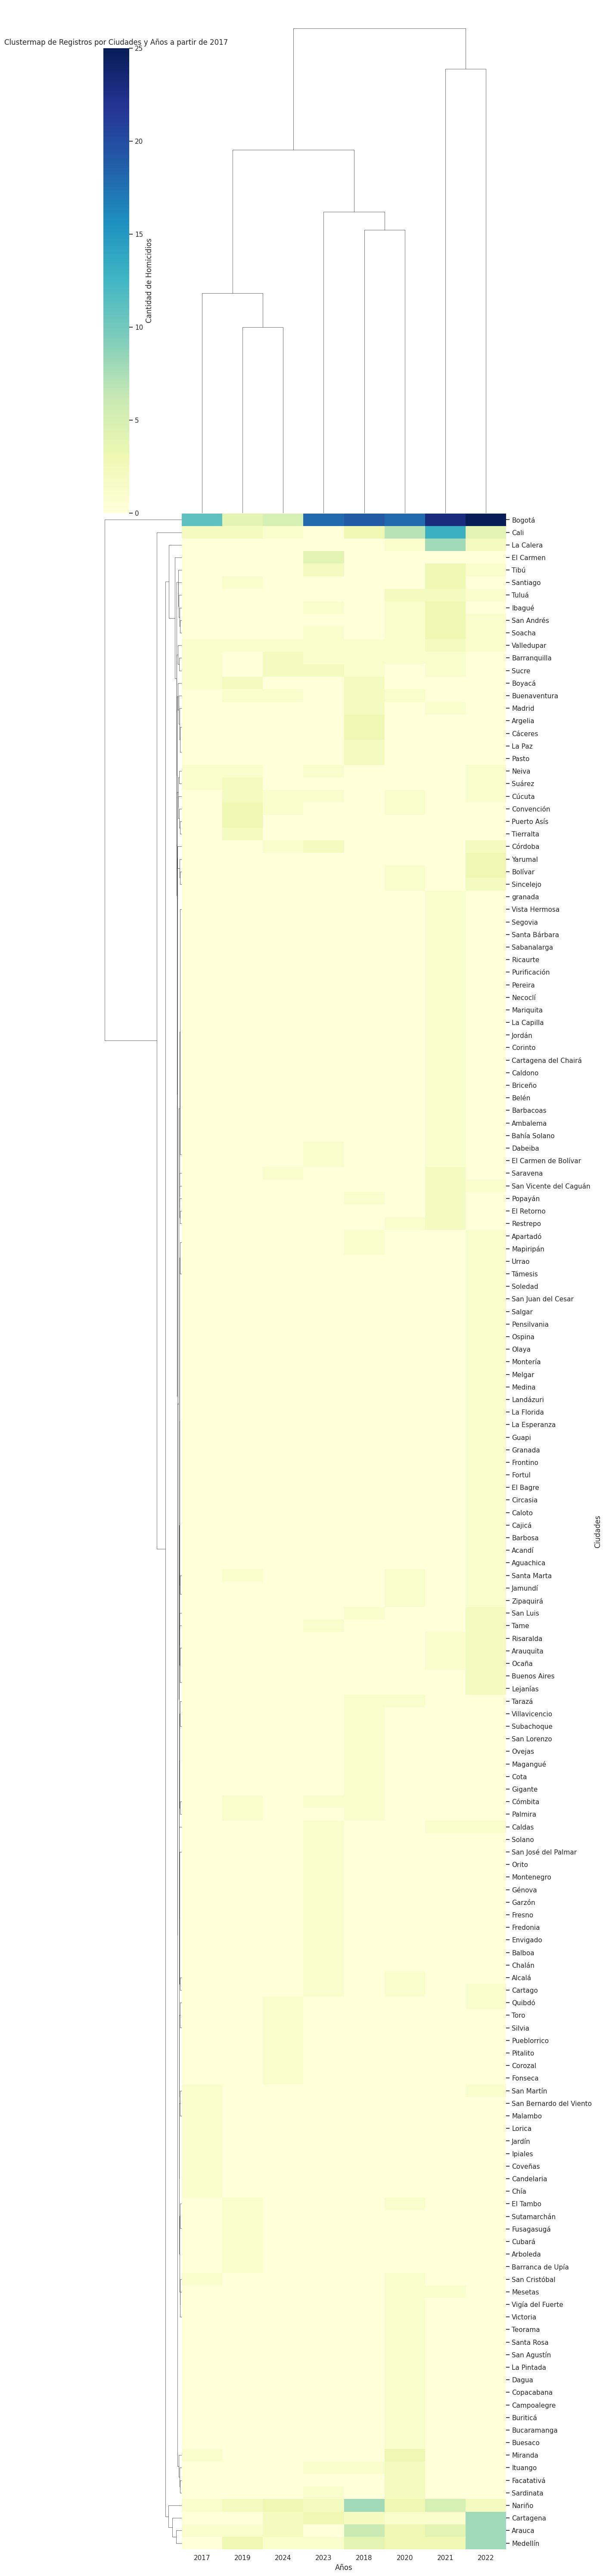

In [ ]:
# Agrupar los datos por Año y Departamento y contar los registros
conteo_por_anio_ciu = df_from2017_est.groupby(['anio_est', 'municipio']).size().reset_index(name='Conteo')
conteo_por_anio_ciu.rename(columns={'anio_est': 'Años'}, inplace=True)
conteo_por_anio_ciu.rename(columns={'municipio': 'Ciudades'}, inplace=True)
conteo_por_anio_ciu.drop(conteo_por_anio_ciu[conteo_por_anio_ciu['Ciudades'] == 'Sin especificar'].index, inplace=True)
conteo_por_anio_ciu

# Crear el DataFrame pivotado para el clustermap
heatmap_data = conteo_por_anio_ciu.pivot(index='Ciudades', columns='Años', values='Conteo').fillna(0)

# Crear el clustermap con dendrograma
sns.clustermap(heatmap_data, fmt=".0f", cmap="YlGnBu",
               col_cluster=True, row_cluster=True,
               cbar_kws={'label': 'Cantidad de Homicidios'}, figsize=(12, 60))

# Configuración del gráfico
plt.title('Clustermap de Registros por Ciudades y Años a partir de 2017')
plt.show()

###Ciudades y Trimestres a partir del 2017

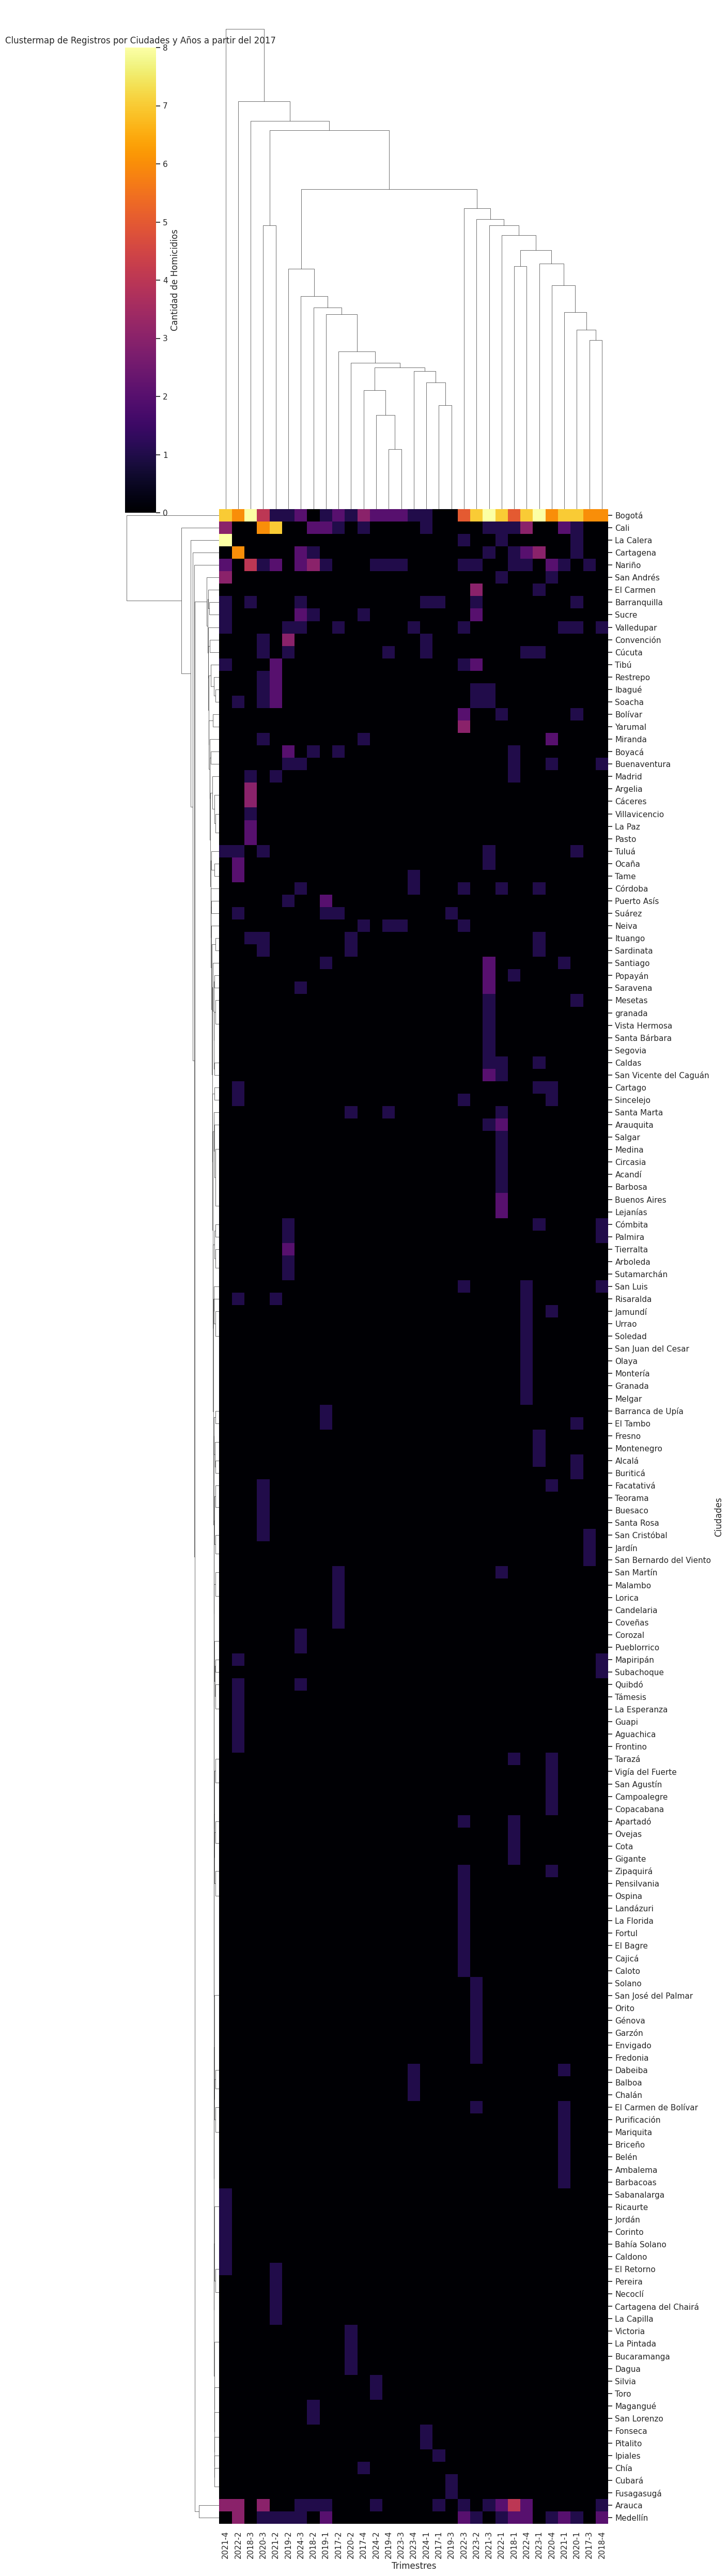

In [ ]:
# Agrupar los datos por Año y Departamento y contar los registros
conteo_por_tri_ciu = df_from2017_est.groupby(['trimestre_est', 'municipio']).size().reset_index(name='Conteo')
conteo_por_tri_ciu.rename(columns={'trimestre_est': 'Trimestres'}, inplace=True)
conteo_por_tri_ciu.rename(columns={'municipio': 'Ciudades'}, inplace=True)
conteo_por_tri_ciu.drop(conteo_por_tri_ciu[conteo_por_tri_ciu['Ciudades'] == 'Sin especificar'].index, inplace=True)
conteo_por_tri_ciu

# Crear el DataFrame pivotado para el clustermap
heatmap_data = conteo_por_tri_ciu.pivot(index='Ciudades', columns='Trimestres', values='Conteo').fillna(0)

# Crear el clustermap con dendrograma
sns.clustermap(heatmap_data, fmt=".0f", cmap="inferno",
               col_cluster=True, row_cluster=True,
               cbar_kws={'label': 'Cantidad de Homicidios'}, figsize=(12, 50))

# Configuración del gráfico
plt.title('Clustermap de Registros por Ciudades y Años a partir del 2017')
plt.show()